
# Jokes Recommender system
### Sekhar Mekala

## Project Requirements

The main goal of this project is to analyze a massive data set with at least 1 million ratings, preferably using a distributed processing system such as Hadoop. In this project, I will be analyzing a 1.7 million continuous ratings (-10.00 to +10.00) of 150 jokes rated by 59132 users. Please visit http://eigentaste.berkeley.edu/dataset/ for more information about the data set. The main deliverables of this project are:
* Develop a collaborative filtering algorithm in a distributed processing environment using PySpark. The algorithm is implemented on 1.7 million ratings data set, in Hadoop environment. We cannot implement the proposed algorithm on a laptop or a stand-alone machine, since the logic of the algorithm requires a self join with the ratings data set, along with complex processing logic. We will be using Spark 1.6.1 version as our distributed processing environment. 

* Develop another recommender system using SGD (Stochastic Gradient Descent) algorithm on a stand alone machine, and evaluate the algorithm's performance on the 1.7 million ratings data set. 

**NOTE** 

* Although we will be building recommender systems using the jokes dataset, the same python code can be used to build similar recommender systems using other data sets also. The only requirement for the implementation of SGD based recommender system is the format of the input data frame. The input data frame must have the following columns:

*user_id,item_id,rating*

The user_id and item_id are integers, and rating can be any real number. There must not be any unavailable or NA values in the input data frame. 

* Please download the jester_ratings.dat and jester_items.dat from http://eigentaste.berkeley.edu/dataset/ (Dataset 2), to follow along the code.

## Recommender system - 1

### Collaborative filtering algorithm

We will develop a collaborative filtering algorithm based on the cosine similarity between the pairs of jokes that are rated by at least one common user. 

We have 2 data sets: *jester_ratings.dat* and *jester_items.dat*. The *jester_ratings.dat* data set has the following format (tab separated):

_user-id_,  _joke-id_,  _rating_

The *jester_items.dat* has the _joke-id_ and the actual joke (HTML text), separated by a ":"

We will be performing the following steps to build a collaborative recommender system using PySpark on Spark environment:

1. Normalize the ratings of the items, based on the following logic. Normalization helps us to remove the user and item biases:

   a. Get the mean rating of each joke. 

   b. Get the mean rating of each user.
   
   c. Subtract the mean ratings of each joke (say _j_) and the mean rating of user (say _u_) from the actual rating of the joke.

2. Using the normalized ratings, compute the cosine similarity between all the pairs of jokes, which are rated by _same users_. The cosine similarity will help us to identify the potential jokes that a user could like based on the jokes which were already liked by the user. To exploit the spark's distributed processing, we will use the following logic to compute the cosine similarity between the pairs of jokes:

   a. Read the contents of jester_ratings.dat into an RDD (Resilient Distributed Dataset), with _user-id_ as the key and _(joke-id, rating)_ as values. Let this RDD be _ratings-rdd_. Pratition the RDD for parallel processing.
   
   b. Get the self join of this RDD (_ratings-rdd_), and filter the rows to eliminate duplicate jokes (details of the filtering process is explained using an example in *Appendix-B*). Let us call this RDD as _joke-pairs-rdd_. The key of this RDD will be _(joke-id-1, joke-id-2)_ and the value will be _(joke-id-1-rating, joke-id-2-rating)_.
   
   c. Group by the _joke-pairs-rdd_ by its keys, and perform the cosine similarity of the values. Let the resulting RDD be called as _jokes-similarity-rdd_. This RDD will have the cosine similarity between the pairs of jokes. The number of users who rated the jokes pairs is also recorded in the RDD
   
   d. Write the _jokes-similarity-rdd_ to HDFS
   
   e. Combine all the components of _jokes-similarity-rdd_ into a single file, and download that file to a local linux directory. The file is finally downloaded to your desired local machine/server location, where the recommendation algorithm will run.

3. To make recommendations to a user:

   a. Read the cosine similarity file into a Pandas data frame. Call this data frame as _jokes-sim-df_
   
   b. Get 5 joke-ids which are rated high by the user
   
   c. For each of the 5 joke-ids, get all the jokes associated with these 5 joke-ids from _jokes-sim-df_. These associated 5 joke-ids must be rated by at least 1000 users. Rank the jokes in the descending order of _similarity measure_
   
   d. Pick the top 5 jokes from the ordered items, and present them to the user. These items must not be already rated by the user. 

See *Appendix-B* for the complete implementation of this process using PySpark. *Appendix-A* contains a detailed walk through of the above logic on a small data set. Using the process explained in *Appendix-B*, we can obtain a file (jokes_sim.txt) that contains the cosine similarity between each pairs of jokes, along with the number of users who rated both the jokes in the pair. We will use this file to build our collaborative recommender system. 


### Importing the required python packages
The following block imports all the required python packages for this project.

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display # Allows the use of display() for DataFrames
import time
import warnings
import itertools    
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.sparse.linalg import svds
from bs4 import BeautifulSoup #To extract text from HTML
import io #To process buffer data

### Reading the similarity measures data

The following code will read the jokes_sim.txt file (produced by the PySpark program in *Appendix-B*), cleans the data and creates a data frame with the following format given below. If you do not have Spark environment, you may download the jokes_sim.txt from the Github location (https://goo.gl/mEE6G6) of this project and build the recommender directly using the cosine similarity scores in the jokes_sim.txt file.

In [2]:
import io
with open('jokes_sim.txt', 'r') as file :
    filedata = file.read()

# Replace the target string
filedata = filedata.replace('(', '')
filedata = filedata.replace(')', '')
jokes_sim_df=pd.read_csv(io.BytesIO(filedata), header=None )
jokes_sim_df.columns = ["Joke-1","Joke-2","Sim-score","Total-votes"]
print "Some of the records from the joke similarity scores:"
display(jokes_sim_df.head())

Some of the records from the joke similarity scores:


,Joke-1,Joke-2,Sim-score,Total-votes
0,34,124,0.122780,3604
1,30,60,0.223450,4164
2,94,144,0.129519,5521
3,42,132,0.255833,6989
4,20,54,0.104506,265


The data in the similarity scores data frame should be interpreted as follows:
1. The column _Joke-1_ represents a joke ID
2. The column _Joke-2_ represents another joke ID. Both _Joke-1_ and _Joke-2_ were rated by at least one user in common
3. The column _Sim-score_ represents the cosine similarity between _Joke-1_ and _Joke-2_. The range of this similarity is [-1, 1]. Greater the similarity score, more similar are the jokes.
4. The column _Total-votes_ represents the number of people who voted both the jokes present in _Joke-1_ and _Joke-2_ columns in common
5. For a joke ID _j_ in _Joke-1_ column, the related joke IDs in _Joke-2_ column are greater than joke ID _j_. For example, for joke ID 42 (Joke-1 = 42), the Joke-2 column must be greater than 42. See the below display of some of the records where Joke-1 = 42


In [4]:
print "Displaying some of the records, where Joke-ID = 42"
display(jokes_sim_df[jokes_sim_df["Joke-1"] == 42].sort(["Joke-2"]).head(15))

Displaying some of the records, where Joke-ID = 42


,Joke-1,Joke-2,Sim-score,Total-votes
5272,42,43,-0.074450,127
4449,42,44,0.089601,4084
5112,42,45,0.185390,5274
4284,42,46,0.252586,6110
4108,42,47,0.166835,6967
8172,42,48,0.178894,6662
8901,42,49,0.195952,6973
8024,42,50,0.205549,8006
7857,42,51,0.262250,129
7000,42,52,0.163794,136


### Getting the jokes text
The following code will process the *jester_items.dat*, extracts the joke IDs and the jokes text, and outputs a data frame called *items_df*. This data frame will be referenced to extract the Jokes text, based on a joke ID.

In [3]:
##Use bs4 to extract the text from HTML documents
from bs4 import BeautifulSoup

with open("jester_items.dat", 'r') as file :
    filedata = file.read()

soup = BeautifulSoup(filedata)
text = soup.get_text() 

#Output the text to a file.
with open("output.txt", "wb") as outfile:
    outfile.write(text)

#Define a list "l"    
l = list()
for line in open(r'output.txt'):
    #if line != " ": 
        l.append(line.strip(":\n"))
#print l

##Weed out empty elements from the list
l = [i for i in l if i != ''] 

## Define a function that checks if a string has a number
def RepresentsInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False
##List object to accumulate the joke IDs
id = list()

##List object to accumulate the jokes text
text = list()

##Temporary string object to append jokes text, since
##A joke can be split into more than one elements in "l"
s = str()
for i in l:
    if RepresentsInt(i):
            if len(s) > 0: ##This will ignore the initial condition
                text.append(s)
                s = str()
            id.append(int(i))
    else:
        s = s + " " + str(i)
text.append(s)

pd.options.display.max_colwidth = 10000
items_df = pd.DataFrame(zip(id,text),columns=["Joke-id","Text"])

print "Displaying the text of joke ID 144, to make sure that we parsed the Jokes text correctly"
display(items_df[items_df["Joke-id"] == 144])

Displaying the text of joke ID 144, to make sure that we parsed the Jokes text correctly


,Joke-id,Text
143,144,"A man is driving in the country one evening when his car stalls and won't start. He goes up to a nearby farm house for help, and because it is suppertime he is asked to stay for supper. When he sits down at the table he notices that a pig is sitting at the table with them for supper and that the pig has a wooden leg. As they are eating and chatting, he eventually asks the farmer why the pig is there and why it has a wooden leg. ""Oh,"" says the farmer, ""that is a very special pig. Last month my wife and daughter were in the barn when it caught fire. The pig saw this, ran to the barn, tipped over a pail of water, crawled over the wet floor to reach them and pulled them out of the barn safely. A special pig like that, you just don't eat it all at once!"""


The above display confirms that the text has been cleaned properly, since there are no embedded HTML Tags or any unreadable characters

### Analyzing the similarity scores

**Top 5 similar jokes**

Let us get the top 5 most similar jokes. These joke pairs were rated by at least 1000 users in common. We will extract the jokes text from item_df to display the jokes text.

In [4]:
display_df=jokes_sim_df[jokes_sim_df["Total-votes"] > 1000].sort(["Sim-score"],ascending=[0]).head(5)
print "Top 5 jokes having highest similarity scores and rated by atleast 1000 users"
display(display_df)
#display(jokes_sim_df[jokes_sim_df["Total-votes"] > 1000].sort(["Sim-score"],ascending=[0]).tail(10))
#pd.merge(left=jokes_sim_df,right= items_df, ignore_index=True)
for a, b, c, d in list(zip(display_df["Joke-1"],
                           display_df["Joke-2"],
                           display_df["Sim-score"],
                           display_df["Total-votes"])):
    print "Joke IDs:[{}, {}]. Similarity score: {}, Total votes: {}".format(a,b,c,d)
    print "Text:"
    display(items_df[((items_df["Joke-id"] == a) | (items_df["Joke-id"] == b))])

Top 5 jokes having highest similarity scores and rated by atleast 1000 users


,Joke-1,Joke-2,Sim-score,Total-votes
2184,123,140,0.675881,4224
3039,86,94,0.608029,6061
7150,138,139,0.460189,9707
9510,60,101,0.452867,4078
1452,58,74,0.452844,3754


Joke IDs:[123, 140]. Similarity score: 0.675880827987, Total votes: 4224
Text:


,Joke-id,Text
122,123,"When most people claim to be ""killing time"", it's only an expression. When Chuck Norris kills time, the minutes actually cease to exist."
139,140,Chuck Norris' calendar goes straight from March 31st to April 2nd; no one fools Chuck Norris.


Joke IDs:[86, 94]. Similarity score: 0.60802866823, Total votes: 6061
Text:


,Joke-id,Text
85,86,"A neutron walks into a bar and orders a drink. ""How much do I owe you?"" the neutron asks. The bartender replies, ""For you, no charge."""
93,94,"Two atoms are walking down the street when one atom says to the other, ""Oh, my! I've lost an electron!"" The second atom says, ""Are you sure?"" The first replies, ""I'm positive!"""


Joke IDs:[138, 139]. Similarity score: 0.460188696353, Total votes: 9707
Text:


,Joke-id,Text
137,138,"WASHINGTON (Reuters) - A tragic fire on Monday destroyed the personal library of President George W. Bush. Both of his books have been lost. Presidential spokesman Ari Fleischer said the president was devastated, as he had not finished coloring the second one."
138,139,"In a Veteran's Day speech, President Bush vowed, ""We will finish the mission. Period."" Afterwards, he was advised that he doesn't have to read the punctuation marks."


Joke IDs:[60, 101]. Similarity score: 0.452866716935, Total votes: 4078
Text:


,Joke-id,Text
59,60,What did the Buddhist say to the hot dog vendor? Make me one with everything.
100,101,Did you hear about the Buddhist who refused Novocaine during a root canal? He wanted to transcend dental medication.


Joke IDs:[58, 74]. Similarity score: 0.452843908367, Total votes: 3754
Text:


,Joke-id,Text
57,58,"How many teddy bears does it take to change a lightbulb? It takes only one teddy bear, but it takes a whole lot of lightbulbs."
73,74,"Q: How many stalkers does it take to change a light bulb? A: Two. One to replace the bulb, and the other to watch it day and night."


Based on the related jokes identified, we can infer the following:
* The joke IDs 123 and 140 are about Chuck Norris
* The joke IDs 86 and 94 are about atoms/neutrons/electrons. Observe that these jokes do not share any topic words (neutron and atom/electron). The ID 86 is about neutron, while ID 94 is about atom/electron
* The joke IDs 138 and 139 are about President George W. Bush
* The joke IDs 60 and 101 are about a Buddhist
* The joke IDs 58 and 74 are about light bulbs. Note the spelling of "light bulb". In the 58 joke ID it is spelled as "lightbulb" while 74 ID has "light bulb". But cosine similarity was able to find that these 2 jokes are related to each other based on the user ratings.

Clearly, the cosine similarity measure is identifying the related joke pairs.

** Top 5 dissimilar jokes**

Let us display the top 5 jokes which are dissimilar to each other. Here also we will consider only the jokes that were rated by at least 1000 users in common.

In [5]:
display_df=jokes_sim_df[jokes_sim_df["Total-votes"] > 1000].sort(["Sim-score"],ascending=[0]).tail(5)
print "Top 5 dissimilar scores, based on the cosine similarity score:"
display(display_df)
#display(jokes_sim_df[jokes_sim_df["Total-votes"] > 1000].sort(["Sim-score"],ascending=[0]).tail(10))
#pd.merge(left=jokes_sim_df,right= items_df, ignore_index=True)
for a, b, c, d in list(zip(display_df["Joke-1"],display_df["Joke-2"],display_df["Sim-score"],
                           display_df["Total-votes"])):
    print "Joke IDs:[{}, {}]. Similarity score: {}, Total votes: {}".format(a,b,c,d)
    print "Text:"
    display(items_df[((items_df["Joke-id"] == a) | (items_df["Joke-id"] == b))])

Top 5 dissimilar scores, based on the cosine similarity score:


,Joke-1,Joke-2,Sim-score,Total-votes
1262,106,124,-0.065407,3768
8486,106,141,-0.065697,3730
6592,114,141,-0.076192,3774
8042,127,141,-0.076766,3769
4195,57,127,-0.087814,4326


Joke IDs:[106, 124]. Similarity score: -0.065406866525, Total votes: 3768
Text:


,Joke-id,Text
105,106,"An engineer dies and reports to the pearly gates. St. Peter checks his dossier and says, ""Ah, you''re an engineer--you're in the wrong place."" So, the engineer reports to the gates of hell and is let in. Pretty soon, the engineer gets dissatisfied with the level of comfort in hell, and starts designing and building improvements. After awhile, they've got air conditioning, flush toilets and escalators, and the engineer is a pretty popular guy. One day, God calls Satan up on the telephone and says with a sneer, ""So, how's it going down there in hell?"" Satan replies, ""Hey, things are going great. We've got air conditioning, flush toilets and escalators, and there's no telling what this engineer is going to come up with next."" God replies, ""What?? You've got an engineer? That's a mistake--he should never have gotten down there; send him up here."" Satan says, ""No way."" I like having an engineer on the staff, and I'm keeping him."" God says, ""Send him back up here or I'll sue."" Satan laughs uproariously and answers, ""Yeah, right. And just where are YOU going to get a lawyer?"""
123,124,"Person 1: Hey, wanna hear a great knock-knock joke? Person 2: Sure, What is it? Person 1: Okay, you start. Person 2: Knock-knock. Person 1: Who's there? Person 2: ... Person 1: Hah!"


Joke IDs:[106, 141]. Similarity score: -0.06569676109, Total votes: 3730
Text:


,Joke-id,Text
105,106,"An engineer dies and reports to the pearly gates. St. Peter checks his dossier and says, ""Ah, you''re an engineer--you're in the wrong place."" So, the engineer reports to the gates of hell and is let in. Pretty soon, the engineer gets dissatisfied with the level of comfort in hell, and starts designing and building improvements. After awhile, they've got air conditioning, flush toilets and escalators, and the engineer is a pretty popular guy. One day, God calls Satan up on the telephone and says with a sneer, ""So, how's it going down there in hell?"" Satan replies, ""Hey, things are going great. We've got air conditioning, flush toilets and escalators, and there's no telling what this engineer is going to come up with next."" God replies, ""What?? You've got an engineer? That's a mistake--he should never have gotten down there; send him up here."" Satan says, ""No way."" I like having an engineer on the staff, and I'm keeping him."" God says, ""Send him back up here or I'll sue."" Satan laughs uproariously and answers, ""Yeah, right. And just where are YOU going to get a lawyer?"""
140,141,Jack Bauer can get McDonald's breakfast after 10:30.


Joke IDs:[114, 141]. Similarity score: -0.0761916493432, Total votes: 3774
Text:


,Joke-id,Text
113,114,"Sherlock Holmes and Dr. Watson go on a camping trip, set up their tent, and fall asleep. Some hours later, Holmes wakes his faithful friend. ""Watson, look up at the sky and tell me what you see."" Watson replies, ""I see millions of stars."" ""What does that tell you?"" Watson ponders for a minute. ""Astronomically speaking, it tells me that there are millions of galaxies and potentially billions of planets. Astrologically, it tells me that Saturn is in Leo. Timewise, it appears to be approximately a quarter past three. Theologically, it's evident the Lord is all-powerful and we are small and insignificant. Meteorologically, it seems we will have a beautiful day tomorrow. What does it tell you?"" Holmes is silent for a moment, then speaks. ""Watson, you idiot, someone has stolen our tent."""
140,141,Jack Bauer can get McDonald's breakfast after 10:30.


Joke IDs:[127, 141]. Similarity score: -0.0767660642306, Total votes: 3769
Text:


,Joke-id,Text
126,127,"A little boy goes to his dad and asks, ""What is politics?"" His dad says, ""Well son, let me try to explain it this way: I'm the breadwinner of the family, so let's call me capitalism. Your Mom, she's the administrator of the money, so we'll call her the government. We're here to take care of your needs, so we'll call you the people. The nanny, we'll consider her the working class. And your baby brother, we'll call him the future. Now, think about that and see if that makes sense."" So the little boy goes off to bed thinking about what dad had said. Later that night, he hears his baby brother crying, so he gets up to check on him. He finds that the baby has severely soiled his diaper. So the little boy goes to his parents' room and finds his mother sound asleep. Not wanting to wake her, he goes to the nanny's room. Finding the door locked, he peeks in the keyhole and sees his father in bed with the nanny. He gives up and goes back to bed. The next morning, the little boy says to his father, ""Dad, I think I understand the concept of politics now."" The father says, ""Good, son. Tell me in your own words what you think politics is all about."" The little boy replies, ""Well, while capitalism is screwing the working class, the government is sound asleep, the people are being ignored and the future is in deep shit."""
140,141,Jack Bauer can get McDonald's breakfast after 10:30.


Joke IDs:[57, 127]. Similarity score: -0.087813975336, Total votes: 4326
Text:


,Joke-id,Text
56,57,Why are there so many Jones's in the phone book? Because they all have phones.
126,127,"A little boy goes to his dad and asks, ""What is politics?"" His dad says, ""Well son, let me try to explain it this way: I'm the breadwinner of the family, so let's call me capitalism. Your Mom, she's the administrator of the money, so we'll call her the government. We're here to take care of your needs, so we'll call you the people. The nanny, we'll consider her the working class. And your baby brother, we'll call him the future. Now, think about that and see if that makes sense."" So the little boy goes off to bed thinking about what dad had said. Later that night, he hears his baby brother crying, so he gets up to check on him. He finds that the baby has severely soiled his diaper. So the little boy goes to his parents' room and finds his mother sound asleep. Not wanting to wake her, he goes to the nanny's room. Finding the door locked, he peeks in the keyhole and sees his father in bed with the nanny. He gives up and goes back to bed. The next morning, the little boy says to his father, ""Dad, I think I understand the concept of politics now."" The father says, ""Good, son. Tell me in your own words what you think politics is all about."" The little boy replies, ""Well, while capitalism is screwing the working class, the government is sound asleep, the people are being ignored and the future is in deep shit."""


Looking at the text of these joke pairs, we can infer that they are entirely different from each other.

## Making recommendations using cosine similarity measure
Let us make recommendations for some of the users based on the jokes they rated high. 


In [6]:
##Reading the ratings data set to a file
ratings_df = pd.read_csv("jester_ratings.dat",sep="\t\t",header=None)
ratings_df.columns = ["User_ID", "Joke_ID","Rating"]
print "Initial rows of the ratings data:"
display(ratings_df.head())

Initial rows of the ratings data:


,User_ID,Joke_ID,Rating
0,1,5,0.219
1,1,7,-9.281
2,1,8,-9.281
3,1,13,-6.781
4,1,15,0.875


Let us create a function that takes a user ID as input and recommends some jokes based on the jokes s/he has rated high. The recommended jokes were not already rated by the user. 

**NOTE** I assumed that a person likes a joke, whenever he gives a rating greater than 5. The default rating is 0 (see the website http://eigentaste.berkeley.edu/. The rating's slider bar stays at 0, if the user does not give any rating), +10 is the best possible rating and -10 is the least possible rating. So, I chose 5 as the minimum rating to determine if the user really likes the jokes.

In [7]:
def get_recommendations(user_id,ratings_df,top_n,jokes_sim_df,items_df):
    #Get the top 5 jokes which the user has rated:
    top_user_ratings = ratings_df[(ratings_df["User_ID"] == user_id) & (ratings_df["Rating"] > 5)
                                 ].sort(["Rating"],ascending=[0]).head(5)
    
    print "The user ID: {} has rated these jokes high:".format(user_id)
    display(top_user_ratings)
    
    #for a in list(top_user_ratings["Joke_ID"]):
        #display(items_df[items_df["Joke-id"] == a])
    display(items_df[items_df["Joke-id"].isin(list(top_user_ratings["Joke_ID"]))])    
    #print "Joke IDs:[{}, {}]. Similarity score: {}, Total votes: {}".format(a,b,c,d)
    #print "Text:"
    #display(items_df[((items_df["Joke-id"] == a) | (items_df["Joke-id"] == b))])
    
    #Get the jokes which were already rated by the user
    already_rated = list(ratings_df[(ratings_df["User_ID"] == user_id)]["Joke_ID"])
    recommend_list=list()
    #Get the top recommendations for the user ID:
    for i in list(top_user_ratings["Joke_ID"]):
        recommend_list.append(list(jokes_sim_df[
                (jokes_sim_df["Joke-1"] == i) & (jokes_sim_df["Total-votes"] > 1000)
                 & ~(jokes_sim_df["Joke-2"].isin(already_rated))   
                ].sort(["Sim-score"],ascending=[0]).head(1)["Joke-2"]))
        recommend_list.append(list(jokes_sim_df[
                (jokes_sim_df["Joke-2"] == i) & (jokes_sim_df["Total-votes"] > 1000)
                 & ~(jokes_sim_df["Joke-1"].isin(already_rated))
                ].sort(["Sim-score"],ascending=[0]).head(1)["Joke-1"]))
    recommend_list = [i for i in recommend_list if len(i) > 0]
    #print recommend_list
    recommend_list = [item for sublist in recommend_list for item in sublist]
    #recommendations = list(recommendations.difference(already_rated))
    
    print "Here are the recommended items for the user ID: {}".format(user_id)
    
    display(items_df[items_df["Joke-id"].isin(recommend_list)])
    
    

Getting recommendations for user ID 17 (a random user ID)

In [8]:
get_recommendations(17,ratings_df,5,jokes_sim_df,items_df)

The user ID: 17 has rated these jokes high:


,User_ID,Joke_ID,Rating
755,17,17,10.000
771,17,49,10.000
758,17,20,10.000
766,17,35,10.000
751,17,8,9.938


,Joke-id,Text
7,8,Q. Did you hear about the dyslexic devil worshiper? A. He sold his soul to Santa.
16,17,How many men does it take to screw in a light bulb? One. Men will screw anything.
19,20,What's the difference between a Macintosh and an Etch-a-Sketch? You don't have to shake the Mac to clear the screen.
34,35,"An explorer in the deepest Amazon suddenly finds himself surrounded by a bloodthirsty group of natives. Upon surveying the situation, he says quietly to himself, ""Oh God, I'm screwed."" The sky darkens and a voice booms out, ""No, you are NOT screwed. Pick up that stone at your feet and bash in the head of the chief standing in front of you."" So with the stone he bashes the life out of the chief. He stands above the lifeless body, breathing heavily and looking at 100 angry natives... The voice booms out again, ""Okay....NOW you're screwed."""
48,49,"Three engineering students were gathered together discussing the possible designers of the human body. One said, ""It was a mechanical engineer. Just look at all the joints."" Another said, ""No, it was an electrical engineer. The nervous systems many thousands of electrical connections."" The last said, ""Actually, it was a civil engineer. Who else would run a toxic waste pipeline through a recreational area?"""


Here are the recommended items for the user ID: 17


,Joke-id,Text
25,26,"A guy walks into a bar and sits down next to an extremely gorgeous woman. The first thing he notices about her though, are her pants. They were skin-tight, high-waisted and had no obvious mechanism (zipper, buttons or velcro) for opening them. After several minutes of puzzling over how she got the pants up over her hips, he finally worked up the nerve to ask her. ""Excuse me miss, but how do you get into your pants?"" ""Well,"" she replied, ""you can start by buying me a drink."""
38,39,What is the difference between men and women? A woman wants one man to satisfy her every need. A man wants every woman to satisfy his one need.
46,47,"There was an engineer who had an exceptional gift for fixing all things mechanical. After serving his company loyally for over 30 years, he happily retired. Several years later the company contacted him regarding a seemingly impossible problem they were having with one of their multi-million dollar machines. They had tried everything and everyone else to get the machine fixed, but to no avail. In desperation, they called on the retired engineer who had solved so many of their problems in the past. The engineer reluctantly took the challenge. He spent a day studying the huge machine. At the end of the day, he marked a small ""x"" in chalk on a particular component of the machine and proudly stated ""This is where your problem is."" The part was replaced and the machine worked perfectly again. The company received a bill for $50,000 from the engineer for his service. They demanded an itemized accounting of his charges. The engineer responded briefly One chalk mark: $1. Knowing where to put it: $49,999. He was paid in full and the engineer retired again in peace."
63,64,What is the rallying cry of the International Dyslexic Pride movement? Dyslexics Untie!
104,105,"A couple of hunters are out in the woods in the deep south when one of them falls to the ground. He doesn't seem to be breathing, and his eyes are rolled back in his head. The other guy whips out his cell phone and calls 911. He gasps to the operator, ""My friend is dead! What can I do?"" The operator, in a calm and soothing voice, says, ""Alright, take it easy. I can help. First, let's make sure he's dead."" There is silence, and then a gun shot is heard. The hunter comes back on the line. ""Okay. Now what??"""
125,126,"A Briton, a Frenchman and a Russian are viewing a painting of Adam and Eve frolicking in the Garden of Eden. ""Look at their reserve, their calm,"" muses the Brit. ""They must be British."" ""Nonsense,"" the Frenchman disagrees. ""They're naked, and so beautiful. Clearly, they are French."" ""No way! They have no clothes and no shelter,"" the Russian points out, ""They have only an apple to eat, and they are being told they live in a paradise. Obviously, they are Russian."""


User ID 17 liked the joke ID 17 (about men), and the system has recommended joke ID 39 (which is also about men). Similarly, the joke ID 8 (liked joke) and joke ID 64 (recommended joke) are related (both refer to Dyslexic). Jokes 20 (liked joke) and 39 (recommended joke) are also related, since both are worded similarly "what is the difference between ... ". Joke ID 35 (liked joke) and 105 (recommended joke) are also related both refer to hunters/explorers, killing someone etc. Joke ID 49 (liked joke) and 47 (recommended joke) are related, since both refer to engineer(s). Joke ID 49 (liked joke) and 126 (recommended joke) are also related, since both jokes refer to a series of reasons to determine "who should be or have made something..."

Getting the recommendations for the user ID 1000.

In [9]:
get_recommendations(1000,ratings_df,5,jokes_sim_df,items_df)

The user ID: 1000 has rated these jokes high:


,User_ID,Joke_ID,Rating
38207,1000,15,9.031
38208,1000,16,9.031
38209,1000,17,9.031
38210,1000,18,9.031
38211,1000,19,9.031


,Joke-id,Text
14,15,Q: What did the blind person say when given some matzah? A: Who the hell wrote this?
15,16,Q. What is orange and sounds like a parrot? A. A carrot.
16,17,How many men does it take to screw in a light bulb? One. Men will screw anything.
17,18,"A dog walks into Western Union and asks the clerk to send a telegram. He fills out a form on which he writes down the telegram he wishes to send: ""Bow wow wow, bow wow wow."" The clerk says, ""You can add another 'Bow wow' for the same price."" The dog responded, ""Now wouldn't that sound a little silly?"""
18,19,"Q: If a person who speaks three languages is called ""trilingual,"" and a person who speaks two languages is called ""bilingual,"" what do you call a person who only speaks one language? A: American!"


Here are the recommended items for the user ID: 1000


,Joke-id,Text
23,24,What do you get when you run over a parakeet with a lawnmower? Shredded tweet.
38,39,What is the difference between men and women? A woman wants one man to satisfy her every need. A man wants every woman to satisfy his one need.
43,44,"A horse walks into a bar. The bartender asks ""So, why the long face?"""
56,57,Why are there so many Jones's in the phone book? Because they all have phones.
137,138,"WASHINGTON (Reuters) - A tragic fire on Monday destroyed the personal library of President George W. Bush. Both of his books have been lost. Presidential spokesman Ari Fleischer said the president was devastated, as he had not finished coloring the second one."


The user ID 1000 liked the joke ID 18 (about a dog), and the system has recommended joke ID 44 (about a horse). Also, it looks like the user like jokes which are more like interrogative statements or questions, and the recommended jokes are also of the same form (except the joke ID 138). 

Given the above recommendations, we can infer that the cosine similarity is doing a decent job. However, we have the drawbacks with this recommender system:

1. For a new user, we do not have a good mechanism to provide recommendations (the cold start problem).

2. We assumed that a rating of greater than 5 implies that the user has really liked the joke. This assumption might be incorrect. Based on this criteria, we may not have any jokes to recommend, if a user gives a rating of less than 5 for all the jokes s/he reads.

In summary, we can represent the complete work flow of the collaborative filtering recommender developed above in the form of a flow chart given below:

#### Fig-1: Cosine similarity based recommender work-flow
<img src="process-1.png">

**Steps**
1.	The _Ratings Dataset_ is supplied as input to the PySpark program (in _Appendix-B_)
2.	The PySpark program produces a file _Cosine Similarity dataset_ with cosine similarity scores between the jokes, which are rated in common by at least one user
3.	The *get_recommendations()* is called with the Cosine Similarity Scores and user ID as inputs
4.	The *get_recommendations()* function will use Ratings Dataset to determine the items, which were already liked by the user
5.	Based on the items which were liked by the user, the *get_recommendations()* function will  recommend items to the user
6.	Check if the user updates the item ratings
7.	If user updates any item ratings (implicit or explicit updates), update the *Ratings Dataset* and call *get_recommendations()* again
8.	If the user does not update any item ratings take no action.

In the above workflow, we did not discuss how often we should re-compute the cosine similarity scores. The frequency of similarity scores update depends on what percentage of ratings are updated by the users and the available computing resources. 

## Recommender system - 2

Our second recommender system is based on Stochastic Gradient Descent algorithm. 

### Stochastic Gradient Descent 
We will now evaluate the SGD (Stochastic Gradient Descent) method to factorize the user-item ratings (utility matrix) to predict the ratings a user could give to a joke he never read.

In recommendation systems, we have a Utility matrix that shows the affinity of all users towards all available items. But this Utility matrix is very sparse, since most of the users might not have looked or experienced all items, and the main goal of recommender systems is to identify the potential items the user might be interested in, by predicting the missing elements (or ratings) in the Utility matrix. One way to accomplish this goal is based on matrix factorization method. In matrix factorization method, we must express the Utility matrix as a product of two matrices, in order to estimate the missing entries in the Utility matrix. In mathematical terms, we define our main objective as given below. 

_Objective_: Express the matrix M as a product of U and V. Where _M_ is a _mXn_ matrix, _U_ is a _mXd_ matrix and _V_ is a _dXn_ matrix, and _d_ is the number of latent factors. 


Mathematically, let
$$M=\left[ \begin{array}{cccccc} r_{11} & r_{12} & . & . & r_{1n} \\ r_{21} & r_{22} & . & . & r_{2n} \\ r_{31} & r_{32} & . & . & r_{3n} \\ . & . & . & . & . \\  . & . & . & . & . \\ r_{m1} & r_{m2} & . & . & r_{mn} \end{array} \right]$$
$$U=\left[ \begin{array}{ccc} u_{11} & . & u_{1d} \\ u_{21} & . & u_{2d} \\  u_{31} & . & u_{3d} \\ . & . & . \\ .& . & . \\ u_{m1} & . & u_{md} \end{array} \right]$$ 
$$V=\left[ \begin{array}{ccccc} v_{11} & v_{12} & . & . & v_{1n} \\ v_{21} & v_{22} & . & . & v_{2n} \\ . & . & . & . & . \\v_{d1} & v_{d2} & . & . & v_{dn}\end{array} \right]
$$

Then M can be expressed as the matrix product of U and V, as shown below: 
$$\left[ \begin{array}{cccccc} r_{11} & r_{12} & . & . & r_{1n} \\ r_{21} & r_{22} & . & . & r_{2n} \\ r_{31} & r_{32} & . & . & r_{3n} \\ . & . & . & . & . \\  . & . & . & . & . \\ r_{m1} & r_{m2} & . & . & r_{mn} \end{array} \right] \approx 
\left[ \begin{array}{ccc} u_{11} & . & u_{1d} \\ u_{21} & . & u_{2d} \\  u_{31} & . & u_{3d} \\ . & . & . \\ .& . & . \\ u_{m1} & . & u_{md} \end{array} \right] \left[ \begin{array}{ccccc} v_{11} & v_{12} & . & . & v_{1n} \\ v_{21} & v_{22} & . & . & v_{2n} \\ . & . & . & . & . \\v_{d1} & v_{d2} & . & . & v_{dn}\end{array} \right] $$

In recommender systems, the matrix M is a sparse matrix with many unknown entries. An example of such sparse matrix is shown below:

$$M=\left[ \begin{array}{cccccc}  & r_{12} & . & . & r_{1n} \\ r_{21} &   & . & . & r_{2n} \\ r_{31} &   & . & . &   \\ . & . & . & . & . \\  . & . & . & . & . \\ r_{m1} & r_{m2} & . & . &   \end{array} \right]$$

For such sparse matrices, we cannot use SVD (Singular Value Decomposition) method to factorize the matrix. Hence for recommendation systems, our main objective is to estimate the U and V matrices considering only the available data in M. Once we obtain optimal U and V matrices (based on the available data in M), we can get the matrix product UV, and estimate an approximate value of the missing elements in M, by comparing the corresponding elements between M and UV. Another advantage of U, V factorization is to identify the hidden dimensions (also called latent factors), which map both the user and items to a common set of dimensions/coordinate system. Such mapping will help to identify users/items/user-item pairs, which are near to each other.

Two of the prominent methods to estimate the U and V matrices are: 

* Alternating Least Squares (ALS) 

* Gradient descent method (Stochastic Gradient Descent or SGD)

Spark MLLib has a built-in ALS implementation. But for this project we will use SGD implemented on a non-distributed environment. The goal is to check if SGD can be used on the 1.7 Million ratings data set in a non-distributed environment (a laptop with 16GB RAM), and evaluate the performance of the SGD.


### SGD algorithm

1. Initialize U and V to random values. We can assume 0s for NA values in M, use SVD method to obtain U and V, and use these values as the initial values of U and V.

2. Randomly choose U or V

3. If U is chosen, randomly choose a row _i_ from U. To estimate the row $U_i$, perform the following:

   3a. Get the list of all columns in $M_i$ row, where we have available values. Call these locations as C

   3b. Let $V_C = V[:,C]$, where $V[:,C]$ is the list of all columns in V, corresponding to the column numbers present in C
   
   3c. Estimate new value of $U_i$ as:
$$U^{new}_{i} = U_{i} - \alpha \nabla_{U_{i}} f_{ij}(U_i,V_i)$$ where $\alpha$ is the learning rate, and $\nabla_{U_i}f_{ij}(U_i,V_j)$ is defined as follows:
$$\nabla_{U_i}f_{ij}(U_i,V_j) = [M_i - U_i.V_C].V_C^T + \lambda_1 U_i$$ where $\lambda_1$ is the regularization parameter

4. If V is chosen, randomly choose a column _j_ from V. To estimate the column $V_j$, perform the following:

   4a. Get the list of all rows in $M_j$ column, where we have available values. Call these locations as R

   4b. Let $U_R = U[R,:]$, where $U[R,:]$ is the list of all rows in U, corresponding to the row numbers present in R
   
   4c. Estimate new value of $V_j$ as:
$$V^{new}_{j} = V_{j} - \alpha \nabla_{V_{j}} f_{ij}(U_i,V_i)$$ where $\alpha$ is the learning rate, and $\nabla_{V_{j}}f_{ij}(U_i,V_j)$ is defined as follows:
$$\nabla_{V_{j}}f_{ij}(U_i,V_j) = [M_j - U_R.V_j]^T.U_R + \lambda_2 V_j$$ where $\lambda_2$ is the regularization parameter



### Implementation of SGD

We will code the following 4 functions to compute U and V using SGD method:

**SGD_factorization(M,d, lambda1, lambda2, n, error_diff, seed,alpha)**
In SGD we will estimate the row of U or column of V by choosing randomly U or V and choosing the row from U or column from V randomly. The randomness in choosing the elements is important. The function SGD_factorization function will accept 8 parameters. The first parameter is M (utility matrix), the second parameter is _d_ (the desired number of latent factors), the third parameter is _lambda1_ (regularization factor for computing U's row), _lambda2_ (regularization factor for computing V's column), _n_ is the maximum number of iterations, and *error_diff* is the least acceptable error difference between the consecutive iterations, _seed_ will accept a number which can be used to reproduce the results, and _alpha_ is the learning rate. The algorithm stops updating the elements of U and V once the specified number of iterations is reached or when the error difference between consecutive iterations is less than or equal to *error_diff*


**SGD_compute_U_row(i,M,V,d,lambda1)**
This function will accept 5 variables as inputs, and computes the gradient for a specific row in U, while keeping all other U and V elements constant. The parameters details are given below:

i = desired row number in U that needs to be estimated (row numbers begin from 0)

M = Utility matrix, which needs to be factorized

V = V matrix or factor in the expression M = UV

d = desired number of latent factors or columns in U

lambda1 = regularization parameter


**SGD_compute_V_col(j,M,U,d,lambda2)**
This function will also accept 5 variables as inputs, and computes the gradient for a specific column in V, while keeping all other U and V elements constant. The parameters details are given below:

j = desired column number in V that needs to be estimated (column numbers begin from 0)

M = Utility matrix, which needs to be factorized

U = U matrix or factor in the expression M = UV

d = desired number of latent factors or rows in V

lambda2 = regularization parameter

**get_RMSE_error(M,U,V)**
This function will compute the RMSE between M and UV, considering the available elements only in M. Takes 3 parameters M, U and V. M is the Utility matrix, U is the U component and V is the V component in M = UV. 

The following block implements the SGD algorithm in Python 2.7. 


In [10]:
def get_RMSE(M,U,V):
    return np.sqrt(np.nanmean(np.square(M - np.dot(U,V))))

def SGD_compute_U_row(i,M,U,V,d,lambda1,alpha):
    '''
     i = desired row number in U, which needs to be computed
     M = Utility matrix of size mXn
     V = V component of size dXn
     lambda1 = reg factor
    '''
    num_of_rows, num_of_cols = M.shape
   
    #np.where will return a tuple.
    C = np.where(~np.isnan(M[i,]))[0]
    
    V_C = V[:,C].copy()
    M_i = M[i,:].copy()
    M_i = M_i[~np.isnan(M_i)]
    return alpha*(-1*np.dot((M_i - np.dot(U[i,],V_C)),V_C.T) + lambda1 * U[i,])
    
def SGD_compute_V_col(j,M,U,V,d,lambda2,alpha):
    '''
     j = desired column number in V, which needs to be computed
     M = Utility matrix of size mXn
     U = U component of size mXd
     lambda2 = reg factor
    '''
    num_of_rows, num_of_cols = M.shape
    
    #np.where will return a tuple.
    R = np.where(~np.isnan(M[:,j]))[0]
    
    U_R = U[R,:].copy()
    M_j = M[:,j].copy()
    M_j = M_j[~np.isnan(M_j)]
    return alpha*(-1*np.dot((M_j - np.dot(U_R,V[:,j])).T,U_R) + lambda2 * V[:,j])


def SGD_factorization(M,d, lambda1, lambda2, n, error_diff, seed,alpha):
    import numpy as np
    #Initialize U and V
    M_rows, M_cols = M.shape
    M_non_nan = np.nan_to_num(M)

    U, s, vt = svds(M_non_nan, k=d, ncv=None, tol=0, which='LM', 
                             v0=None, maxiter=None, return_singular_vectors=True)
    #print U
    #print np.dot(np.diag(s),vt)
    #print vt
    V = np.dot(np.diag(s),vt)
    #print "In SGD Factorization..."
    #print "U.shape:{}".format(U.shape)
    #print "V.shape:{}".format(V.shape)
    
    #print V
    #np.random.seed(seed)
    #U = np.zeros((M_rows,d),dtype=np.float)+np.random.rand(M_rows,d)
    #np.random.seed(seed)
    #V = np.zeros((d,M_cols),dtype=np.float)+np.random.rand(d,M_cols)
    error = []
    error.append(get_RMSE(M,U,V))

    for count in xrange(n):
            #Do not use any seed here
            #pick_1 = np.random.random_integers(0,1)
            pick_1 = np.random.randint(0,2)
            if pick_1 == 0:
                #pick_2 = np.random.random_integers(0,M_rows - 1)
                pick_2 = np.random.randint(0,M_rows)
                U[pick_2,] = U[pick_2,] - SGD_compute_U_row(pick_2,M,U,V,d,lambda1,alpha)
                error.append(get_RMSE(M,U,V))
                if np.absolute(error[-2] - error[-1]) <= error_diff:
                    return [U, V, error]
            else:
                #pick_2 = np.random.random_integers(0,M_cols-1)
                pick_2 = np.random.randint(0,M_cols)
                V[:,pick_2] = V[:,pick_2] - SGD_compute_V_col(pick_2,M,U,V,d,lambda2,alpha)
                error.append(get_RMSE(M,U,V))        
                if np.absolute(error[-2] - error[-1]) <= error_diff:
                    return [U, V, error]
    return [U, V, error]

### Building a framework to measure the SGD's performance 

We need to build the following functions to successfully evaluate the algorithm's performance:

* Select a desired number of users randomly. This will help us to test the scalability of our algorithm for different volumes of data, since number of users selected is proportional to the amount of data used.

* Create a Utility matrix based on the selected users-rating data.

* The Utility matrix, will be split into test and training data (20:80 for test:training respectively). A function will be written to perform this split. If only one rating is available for an item, the function must eliminate such item's rating from test data. The split must be random.

* Define a function to obtain the rating present at the intersection of User-Item of the Utility matrix.

* Define a function to normalize the data.

* Define a function to plot the ROC curves.

* Use the above functions and evaluate the algorithm's performance. The following metrics will be used to compare the algorithm's performance for various parameters of the algorithm:
    * RMSE (of both the test and training data)
    * Run time 
    * AUC (Area Under the Curve) in ROC


### Selecting the users randomly

To test the scalability of our algorithm, we must select different amounts of training data, so that the algorithm's performance can be compared by recording the runtimes for different volumes of training data. To achieve this requirement, let us define a python function that randomly selects the data belonging to a given number of users. 

**NOTE:**
We will NOT use the following function (of selecting the users randomly) in this project, since we will use the complete data to train and test our algorithm. However, I included this algorithm so that we have a complete frame work to develop and test SGD algorithm with various volumes of data.

In [11]:
def select_data(user_df, n=10,seed=1234):
    #Selecting only n users randomly
    #Set the seed, to seed to reproduce the same results
    np.random.seed(seed)
    uids = np.random.randint(1,user_df["user_id"].max(),n)

    user_df=user_df.iloc[uids]
    uids = [i+1 for i in uids]

    #Combined data frame
    df = pd.merge(pd.merge(user_df,ratings_df),movie_df)
    #print "All columns combined (sample records):"
    #display(df.head())

    return [df, user_df]

### Building utility matrix
The following function will build the utility matrix. If a user has rated the same joke more than once, then we will take the average of such ratings to represent the user rating.

In [12]:
def build_utility_matrix(df):
        
        ##Confine the columns to just user ID, Item ID, and rating only
        df_final = df[["user_id","item_id","rating"]]

        #Some users have rated the same movie multiple times. So taking mean of such ratings
        df_final = df_final.groupby(["user_id","item_id"]).mean()
        df_final = df_final.reset_index()

        #Building the utility matrix
        Utility = df_final.pivot(index="user_id",columns="item_id",values="rating")
        Utility.columns.names=[" "]
        return Utility

### Splitting the data into test and train data sets
We will create a function that takes Utility matrix as input, along with the test data's size (expressed in percentage), and returns test and training data as output.

The function will first identify the cells in the utility matrix where a joke has been rated by at least 2 users, and randomly pick the desired percentage of such cells as test data. This way we can eliminate the chance of picking any joke rated by single user as test data. So, unless a joke has at least 2 ratings, we will not consider that joke to test our algorithm's performance.

NOTE: In these functions, we assume that the rows of Utility matrix represent the user IDs and the columns represent the items.

In [13]:
#Define a function that gets the ratings values at the 
#intersection of row_idx and col_idx values, where
#row_idx and col_idx are lists

def get_ratings(Utility,row_idx,col_idx,indices=True):
    '''
       row_idx and col_idx are lists containing the indices of the utility matrix.
       If indices=True, then the row_idx and col_idx represent the actual index value and column name
       else, they represent the row number and column number respectively. 
        
    '''
    ratings = list()
     
    if len(row_idx) == len(col_idx):
        if indices:
            for i in xrange(len(col_idx)):
                ratings.append(Utility.loc[row_idx[i],col_idx[i]])
        else:
            for i in xrange(len(col_idx)):
                ratings.append(Utility.iloc[row_idx[i],col_idx[i]])
        return ratings
    else:
        print "Error. The lengths of the row and col locations must be same"


def split_data(Utility,test_perc=20):
        #What number makes the 20% of the ratings?
        #Find the cell locations where there is a true rating.
        rows,cols=np.where(~np.isnan(Utility))

        #What percentage of cells have the true rating?
        nan_perc = 100-100*float(len(cols))/(Utility.shape[0]*Utility.shape[1])
        non_nan_perc = 100*float(len(cols))/(Utility.shape[0]*Utility.shape[1])
        
        #Find the number of observations needed for the test data
        test_number = np.trunc(test_perc / 100.0 * len(cols))
        
        #Find the locations (row,col) in the Utility matrix
        #wherever we have a genuine value. The ratings_locations data frame (defined below)
        #will have these (row-column) details.
        ratings_locations = pd.DataFrame(zip(rows,cols),columns = ["row","column"])

        #Get the column locations which have at least 2 ratings.
        #This will make sure that we do not accidentally select a 
        #rating (which is the only rating available for the item or row) 
        ratings_counts = ratings_locations.groupby(["column"])['row'].count()
        #print ratings_counts
        
        #display(ratings_counts)
        cols_num_2_ratings = list(ratings_counts[ratings_counts>1].index)
        test_row_num = list()
        test_col_num = list()

        sample_count = 0
        
        train_df = Utility.copy()
        for i in cols_num_2_ratings:
            #The random choice is important. It helps us to randomly 
            #select the row location so that we do not select the value from the 
            #same row location.
            
            #Get the location of the row and columns into variables
            temp_test_row = np.random.choice(np.where(~np.isnan(Utility.iloc[:,i]))[0])
            temp_test_col = i
            
            #Keep a track of the sample size
            sample_count = sample_count + 1
            
            #If a user-item pair is selected for test, make that value as NA in training data 
            #However, there is a chance that the whole row could be NA, after this operation,
            #since a column might be already selected and made as NA.
            #So save the current value in tem_value, and 
            #re-assign to the same row-column value in train_df, if the operation
            #results in the whole row filled with NA.
            temp_value=train_df.iloc[temp_test_row,temp_test_col]
            train_df.iloc[temp_test_row,temp_test_col] = np.nan
            ##Undo the change in training data, if the change results in all NAs in the row
            if np.isnan(train_df.iloc[temp_test_row,:]).all():
                sample_count = sample_count - 1
                train_df.iloc[temp_test_row,temp_test_col] = temp_value
                continue
            test_row_num.append(temp_test_row)
            test_col_num.append(temp_test_col)
            
            #Stop data selection once we obtain the desired number of samples
            if sample_count >= test_number:
                break
            
        
        ##Get the ratings at the intersection of row and column numbers from the 
        ##Utility matrix
        test_ratings=get_ratings(Utility,test_row_num,test_col_num,indices=False)

        ##Prepare the test data frame
        user_id = [Utility.index[i] for i in test_row_num]
        item_id = [Utility.columns[i] for i in test_col_num]

        test_df = pd.DataFrame(zip(test_row_num,test_col_num,
                           user_id,
                           item_id,
                           test_ratings),columns=["row_number","column_number","user_id","item_id","rating"])
        
        return [train_df,test_df]

## Normalize the Utility matrix

We will define a function _normalize(M)_ that performs the normalization of Utility matrix _M_ based on the following logic. Normalization helps us to eliminate user and item biases.

*normalize(M):* This function takes numpy matrix M as input and normalizes the matrix's data using the following logic:
1. For each row, get the respective mean (ignoring the NANs).
2. Subtract the means obtained in step-1 from the respective rows
3. Get the means of the columns of the modified matrix from step-2
4. Subtract the column means from the respective columns of the modified matrix, obtained in step-2

**NOTE:**
The following block implements the normalization in Python. But we also used the same normalization technique in PySpark also. Refer to *Appendix-B* for the implementation of normalization using PySpark.

In [155]:
##Normalize the Utility matrix:
##Subtract the avg user rating and avg item rating from the item in M
#print M
def list_mean(l):
    if np.isnan(l).all():
        print "list_mean() message: All NA values. Check the logic."
    return np.nanmean(l)

def normalize(M):
    #Convert M to a numpy array
    #print "In normalize"
    M = np.array(M)
    
    #Get the column means (or items mean)
    items_mean=np.apply_along_axis(list_mean,0,M)
    
    #If an item is NOT rated by any user, then we will get NA for mean
    #So for such instances
    if np.isnan(np.sum(items_mean)):
        print "WARNING: Items has NAN values. which is incorrect"

    #Subtract the columns mean from the respective columns
    M_normalized = M[:,] - items_mean
    
    #Get the rows means (or users mean) using the partially normalized matrix
    users_mean = np.apply_along_axis(list_mean,1,M)
    if np.isnan(np.sum(users_mean)):
        print "WARNING: Users has NAN values. which is incorrect"

    #Subtract the rows means
    M_normalized = (M_normalized[:,].T- users_mean)
    
    #Transform back and return
    return [M_normalized.T, items_mean, users_mean]

The work-flow and the role of various functions defined for the computation of U and V factors, based on SGD method is shown below:

### Figure 2: SGD based recommender work-flow
<img src="process-2.png">

**Steps**
1. The pandas data frame "Ratings data" (with columns: user_id, item_id, rating) is supplied as input to *build_utility_matrix()* function. The input data frame MUST have only 3 columns with the names: user_id, item_id, rating representing the user ID, item ID and rating respectively. The user ID and item ID clumns must be integers, and the rating column can be a any real number.
2. *build_utility_matrix()* produces *Utility Matrix* as output
3. *Utility Matrix* is supplied as input to *split_data()*, and *split_data()* produces two data frames: Test and training, In this process, split_data() utilizes the function *get_ratings()*, which gets the rating from the utility matrix based on the column and row indices or column and row numbers. The splitting of the data happens randomly
4. The training data frame is supplied as input to *normalize()* function. The *normalize()* function utilizes *list_mean()*, which computes the mean of the input list ignoring the NA values 
5. The *normalize()* function produces a normalized data frame using the training data
6. The normalized data frame is supplied as input to *SGD_factorization()* function. The *SGD_function()* will make use of the functions *SGD_compute_U_row()*, *SGD_compute_V_col()* and *get_RMSE()*. The *SGD_compute_U_row()* will adjust the values of the U matrix's row, the *SGD_compute_V_col()* will adjust the V matrix's column, and the *get_RMSE()* will be used to compute the Root Mean Squared error (RMSE) between the normalized matrix and UV matrix product. Since the normalized input matrix is sparse, only the available elements in the input matrix will be used to compute the RMSE
7. The *SGD_factorization()* will produce U and V factors, which are optimized based on the SGD algorithm
8. The U and V matrices are multiplied to get the UV matrix. This UV matrix will have the same dimensions as the Utility matrix, but the UV matrix will have al the elements unlike the Utility matrix (which is a sparse matrix).
9. The test data, UV matrix are used to compute the test RMSE error

In the next section, we will show how these steps are combined to obtain the optimal parameters for the SGD algorithm.

## Tuning SGD algorithm's parameters

For SGD algorithm, we have the following parameters to tune:

* $\lambda_1$: The regularization parameter while finding U matrix
* $\lambda_2$: The regularization parameter while finding V matrix
* $d$: Desired number of latent factors
* $n$: Number of users to select. This indirectly controls the volume of the training data

* In our evaluation, we will use the same values for $\lambda_1$ and $\lambda_2$. We will use the following values for these parameters:

$$\lambda_{1,2} = [0.1,1,2,3,4,5,10,100]$$

* We will select $n$ as $59132$. We have a maximum of 59132 users in the data set

* Out of the _n_ users ratings, 80% of data will be used for training and 20% for testing. The training data and test data are randomly selected

* The value of $d$ (latent factors) will have the following values:
$$d=[2,5,10,15,20,25,30,35,40,50,60,80,100]$$

* We will use a constant learning rate of 0.00001

* For each parameter combination, we will get the test and training error

* The experiment is repeated 5 times. For each iteration, we select 80% of the data for training and 20% of the data for testing

* The average of test and training errors for all the parameters combinations in all the iterations are obtained. The least average test error is finally picked as the optimal set of parameters to implement the SGD algorithm for the Jokes data set


**NOTE:**
Do NOT execute the following code, since this code will run for a while. It ran for 1 hour on a computer with 16GB RAM. To save time, I saved the performance metrics of various parameters combinations in a file named "performance_df.csv". This file can be downloaded from the Github location: https://goo.gl/mEE6G6

In [17]:
#Rename the ratings_df columns, since the build_utility() function requires these column names: 
#["user_id","item_id","rating"]

ratings_df.columns = ["user_id","item_id","rating"]

#Initialize the lambda1 values
#The same values will be used for lambda2 also
lambda1 = [0.1,1,2,3,4,5,10,20,30,40,100]

#Select the ratings data based on the 
#following number of users
total_users = [59132]

#lambda1 = [1,2]
#total_users = [20,30]

#Learning rate for SGD
alpha = 0.00001
#alpha = [0.01, 0.001, 0.0001, 0.00001, 0.0000001,0.000000001]

#Error tolerance
#Maximum error acceptable to terminate the iterations
error_diff = 0.0000000001

#Seed to reproduce the results
seed = 10

#Place holders for metrics
reg = []
num_of_users = []
latent_factors = []
train_error = []
test_error = []
run_time = []
algorithm = []
iterations = []
LR = []
#Maximum number of iterations
n = 1000
from time import time

df = ratings_df.copy()
Utility = build_utility_matrix(df)
train_df,test_df=split_data(Utility,test_perc=20)
epoch = list()
for episode in [1,2,3,4,5]:
    print "Training episode: {}".format(episode)
    train_normalized,train_items_mean,train_users_mean = normalize(train_df)
    train_users=train_df.shape[0]
    for a in lambda1:
        #print "evaluating lambda={} iteration".format(a)
        c = [2,5,10,15,20,25,30,35,40,50,60,80,100]
        for d in c:
            #Running SGD for the given parameters combination
            #for rate in alpha:
                #LR.append(rate)
                algorithm.append("SGD")
                reg.append(a)
                num_of_users.append(b)
                latent_factors.append(d)
                start = time() # Get start time
                U, V, error = SGD_factorization(np.array(train_normalized),d, a, a, n, error_diff, seed,alpha)
                end = time() # Get start time
                train_error.append(error[-1])
                iterations.append(len(error))
                run_time.append(end-start)

                temp_UV = np.dot(U,V) + train_items_mean
                temp_UV = temp_UV.T + train_users_mean
                temp_UV = temp_UV.T
                predicted_ratings = get_ratings(pd.DataFrame(temp_UV),list(test_df["row_number"]),
                                                   list(test_df["column_number"]),indices=False)
                test_error.append(np.sqrt((np.nanmean(np.square(
                                    np.array(test_df["rating"]) - np.array(predicted_ratings))))))
                epoch.append(episode)

Training episode: 1
Training episode: 2
Training episode: 3
Training episode: 4
Training episode: 5


The performance metrics obtained for various parameters combinations (for all the 5 training episodes) are written to a file, so that we do not have to re-execute the above code block again. 



In [156]:
#performance_df = pd.DataFrame(zip(algorithm,reg,num_of_users,latent_factors,run_time,
#                                  train_error,test_error,iterations,epoch),
#                             columns=['algorithm','reg','num_of_users','latent_factors',
#                                      'run_time','train_error','test_error','iterations','epoch'])

##Writing the performance metrics to a file, so that we do not have to
##run the above block again
#performance_df.to_csv("performance_df.csv")
performance_df = pd.read_csv("performance_df.csv")
#display(performance_df.sort(["test_error"]))

display_df = performance_df.groupby(['algorithm',
                                     'reg','num_of_users',
                                     'latent_factors']).mean().reset_index().sort("test_error")[['algorithm',
                                                                                                 'reg',
                                                                                                 
                                                                                                 'latent_factors',
                                      'run_time','train_error','test_error','iterations']]
display_df.columns = ["Algorithm","Reg","Latent_Factors","Avg_Run_Time",
                      "Avg_Training_Error","Avg_Test_Error","Avg_Iterations"]
print "Average performance metrics obtained for various parameters combinations."
print "\nThe metrics are sorted in the increasing order of average TEST error"
print "\nDisplaying the top rows only."
display(display_df.head(10))


print "Displaying the performance metrics sorted in the increasing order of TRAINING error:"
display(display_df.sort(["Avg_Training_Error"]).head(5))

Average performance metrics obtained for various parameters combinations.

The metrics are sorted in the increasing order of average TEST error

Displaying the top rows only.


,Algorithm,Reg,Latent_Factors,Avg_Run_Time,Avg_Training_Error,Avg_Test_Error,Avg_Iterations
23,SGD,1.0,60,3.2880,1.890782,3.695142,7.0
140,SGD,100.0,60,6.5704,1.890789,3.695788,23.0
127,SGD,40.0,60,4.5240,1.890779,3.695791,13.2
114,SGD,30.0,60,4.4480,1.890782,3.695791,12.6
101,SGD,20.0,60,6.2584,1.890778,3.695793,21.2
49,SGD,3.0,60,4.4800,1.890769,3.695793,13.0
36,SGD,2.0,60,4.6008,1.890782,3.695793,13.4
10,SGD,0.1,60,3.0220,1.890780,3.695793,5.8
75,SGD,5.0,60,4.6580,1.890803,3.695793,13.2
62,SGD,4.0,60,3.1560,1.890777,3.695793,6.2


Displaying the performance metrics sorted in the increasing order of TRAINING error:


,Algorithm,Reg,Latent_Factors,Avg_Run_Time,Avg_Training_Error,Avg_Test_Error,Avg_Iterations
129,SGD,40.0,100,2.9224,1.009886,3.739950,6.4
64,SGD,4.0,100,2.9700,1.009887,3.739955,6.2
25,SGD,1.0,100,2.2340,1.009889,3.739955,3.4
77,SGD,5.0,100,3.5940,1.009889,3.739955,9.6
51,SGD,3.0,100,3.8440,1.009889,3.739955,10.4


From the above display, we can infer the following:
* The optimal number of latent factors is 60, since the average test error is the least for 60 latent factors.
* The Regularization (Reg) parameter has no effect on the average test error, since the test error almost the same for all the regularization parameters, and with 60 latent factors.
* The average training error for 100 latent factors is minimum, but the average test error is not the minimum for 100 latent factors. This suggests that overfitting is happening at 100 latent factors

Since Reg value has no significant effect on the test error, we will choose the following parameters combination as the optimal combination:

$$Reg = 1, \mbox{Latent Factors} = 60, \mbox{Learning rate} =  0.00001$$

Note that we did NOT vary the learning rate while gathering the performance metrics. Just to make sure *how* the learning rate effects the test error, the following code block will use the [0.01, 0.001, 0.0001, 0.00001, 0.0000001,0.000000001] values as the learning rate, along the with the above parameter values, and computes the test error for each learning rate.  


In [21]:
train_error_1 = list()
test_error_1 = list()
iterations_1 = list()
ratings_df.columns = ["user_id","item_id","rating"]
df = ratings_df.copy()
Utility = build_utility_matrix(df)
train_df,test_df=split_data(Utility,test_perc=20)
#train_users_1=train_df.shape[0]
train_normalized,train_items_mean,train_users_mean = normalize(train_df)

#print train_users

#SGD_factorization(np.array(train_normalized),d, a, a, n, error_diff, seed,alpha)
alpha_1 = [0.01, 0.001, 0.0001, 0.00001, 0.0000001,0.000000001]

for rate in alpha_1:
    print "Evaluating LR = {}".format(rate)
    U, V, error = SGD_factorization(np.array(train_normalized),60, 1, 1, 1000, 0.0000000001, 10,rate)
    #print error[-1]

    train_error_1.append(error[-1])
    iterations_1.append(len(error))
    temp_UV = np.dot(U,V) + train_items_mean
    temp_UV = temp_UV.T + train_users_mean
    temp_UV = temp_UV.T


    predicted_ratings = get_ratings(pd.DataFrame(temp_UV),list(test_df["row_number"]),
                                                   list(test_df["column_number"]),indices=False)
    test_error_1.append(np.sqrt(np.nanmean(np.square(np.array(test_df["rating"]) - np.array(predicted_ratings)))))

print "Test Error for various learning rates:"
pd.DataFrame(zip(alpha_1,test_error_1),columns = ["Learning Rate", "Test Error"])

Evaluating LR = 0.01
Evaluating LR = 0.001
Evaluating LR = 0.0001
Evaluating LR = 1e-05
Evaluating LR = 1e-07
Evaluating LR = 1e-09
Test Error for various learning rates:


,Learning Rate,Test Error
0,1.000000e-02,7843.162685
1,1.000000e-03,4.231813
2,1.000000e-04,4.231626
3,1.000000e-05,4.231626
4,1.000000e-07,4.231626
5,1.000000e-09,4.231626


The learning rate of 0.01 is not optimal. But any other learning rate listed in the above display is optimal, although we stick to the learning rate value of 0.00001, which was used to evaluate the algorithm's performance for various parameters combinations. Also we will select the learning rate which is not too slow (since the convergence will take a long time) or too fast, since the overshooting may occur. In the above display, we obtained a huge test error of 7843, because of overshooting in the gradient descent algorithm.

### Training the best model and evaluating the ROC Area

We will use the following parameters to train the SGD model and plot the ROC (Receiver Operating Characteristic) curves to identify if the SGD model's performance is acceptable. These are the parameters which were identified based on the average test error in 5 different runs of the SGD algorithm using different sets (randomly selected) of training data.

$$Reg = 1$$

$$\mbox{Latent Factors} = 60$$

$$\mbox{Learning rate} =  0.00001$$

If the AUC (Area Under the ROC Curve) is less than or equal to 0.5, then our model is not a good model and our model is no better than just random guessing. 

In [19]:
#Train the model with the optimal parameter combinations identified
train_df,test_df=split_data(Utility,test_perc=20)
train_normalized,train_items_mean,train_users_mean = normalize(train_df)


U, V, error = SGD_factorization(np.array(train_normalized),60, 1, 1, 1000, 0.0000000001, 10,0.00001)
#In the above call, we used 60 latent factors, regularization parms as 1, 1
#0.0000000001 is the error tolerance (stop the iteration if the consecutive errors difference is less than
# or equal to 0.0000000001)
#Learning rate is 0.00001

pred = np.dot(U,V) + train_items_mean
pred = pred.T + train_users_mean
pred = pred.T
# pred will have the same shape as the utility matrix. 
# But pred matrix will have an estimate of the missing entries in the Utility matrix

### Getting the test data predictions SGD
The following code will get the predicted ratings for the test data using SGD method. Whenever our model predicts a rating of more than 10 or less than -10, we change that rating to 10 and -10 respectively. Also we will normalize the predicted ratings using the following formula:

$$x_{new} = \frac{x - x_{min}}{x_{max} - x_{min}}$$

Since our ratings always belong to $[-10,10]$, we can re-write the above formula as:

$$x_{new} = \frac{x - (-10)}{10 - (-10)} = \frac{x +10}{20}$$

The main advantage of this scaling is that all the new ratings will have a value between $[0,1]$. These new values can be interpreted as the probability that a user likes the movie, and this interpretation will help us to plot the ROC curve for our model.


In [20]:
#Get the predicted ratings for the test data
SGD_predicted_ratings = get_ratings(pd.DataFrame(pred),list(test_df["row_number"]),
                                               list(test_df["column_number"]),indices=False)

SGD_predicted_ratings = np.array(SGD_predicted_ratings)

#If any predicted rating is more than 10, then make that rating as 10
SGD_predicted_ratings[SGD_predicted_ratings > 10] = 10

#If any predicted rating is less than -10, then make that rating as -10
SGD_predicted_ratings[SGD_predicted_ratings < -10] = -10

#Normalize the rating to [0,1] interval
SGD_predicted_prob = (SGD_predicted_ratings+10)/20

Adding the predicted ratings and probabilities to the test data

In [21]:
##Add the predicted ratings and probabilities (normalized ratings) to the test data frame
test_df["SGD_predicted_ratings"] = SGD_predicted_ratings
test_df["SGD_predicted_prob"] = SGD_predicted_prob
test_df.head()

,row_number,column_number,user_id,item_id,rating,SGD_predicted_ratings,SGD_predicted_prob
0,48,0,55,5,-6.656,-6.728410,0.163579
1,39437,1,42402,7,-6.938,-7.884690,0.105765
2,2106,2,2281,8,-5.594,1.388690,0.569434
3,40590,3,43612,13,0.188,-0.638931,0.468053
4,42453,4,45579,15,-6.656,0.787004,0.539350


To change the ratings prediction problem as a binary classification (like/dislike) problem, we assume that a user likes a joke, if he gives a rating of more than 5, and dislikes the joke, if he rates the joke less than or equal to 5. Based on this assumption, we will add a new column "actually_liked" to the test data. This column will have a 1 if the user has given more than 5 rating to a joke, else this column will have 0.

In [22]:
#Make a copy of the rating
actually_liked = test_df["rating"].copy() 

#Encode the probability score as 0/1 to represent the prediction that the user really likes or dislikes 
#1 - if the user likes the joke
#0 - if the user dislikes the joke
actually_liked[actually_liked <= 5] = 0
actually_liked[actually_liked > 5] = 1
test_df["actually_liked"]=actually_liked

print "Diplaying a set of initial rows from the test data:"
test_df.head()

Diplaying a set of initial rows from the test data:


,row_number,column_number,user_id,item_id,rating,SGD_predicted_ratings,SGD_predicted_prob,actually_liked
0,48,0,55,5,-6.656,-6.728410,0.163579,0.0
1,39437,1,42402,7,-6.938,-7.884690,0.105765,0.0
2,2106,2,2281,8,-5.594,1.388690,0.569434,0.0
3,40590,3,43612,13,0.188,-0.638931,0.468053,0.0
4,42453,4,45579,15,-6.656,0.787004,0.539350,0.0


### Plotting the ROC curve

The following code will plot the ROC curve for our predictive model

SGD Area Under the Curve:0.907134502924


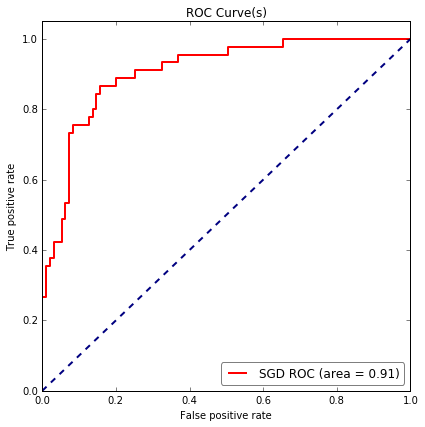

In [23]:
#Let us create a function to plot the ROC curves
def plot_roc_curves(fpr,tpr,ax,models,colors=["red","green","darkorange","green","black","magenta","cyan"]):
    import matplotlib.pyplot as plt
    from sklearn.metrics import auc
    lw=2 #Line weight
    for key in range(len(fpr)):
        line1, = ax.plot(fpr[key], tpr[key], linewidth=2,color=colors[key],
                 label=models[key]+' ROC (area = %0.2f)' % auc(fpr[key],tpr[key]))
    line2,=ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.legend(loc='lower right',fancybox=True, framealpha=0.5)
    
    ax.set_ylabel('True positive rate')
    ax.set_xlabel('False positive rate')
    ax.set_title('ROC Curve(s)')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    return ax



##Import the required packages
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#Dictionary to collect the False Positive Rates at various probabilities thresholds
fpr = dict()

#Dictionary to collect the True Positive Rates at various probabilities thresholds
tpr = dict()

#Dictionary to collect the probability thresholds used to compute the TPR and FPR
thresholds=dict()

#Get the probabilities that the target class=1 
SGD_clf_test_scores=np.array(test_df["SGD_predicted_prob"])

#Get the FPR, TPR, thresholds used for unoptimized classifier
fpr[0], tpr[0], thresholds[0] = roc_curve(test_df["actually_liked"], y_score=SGD_clf_test_scores, pos_label=1)
print "SGD Area Under the Curve:" + str(auc(fpr[0],tpr[0]))

fig, ax = plt.subplots(figsize=(6,6))
#fig.suptitle('Categorical variables bar plots')
models=["SGD"]
plot_roc_curves(fpr,tpr,ax,models)
plt.tight_layout()

### Finding the optimal threshold

Using the test data, we obtained an AUC of 0.91, which is a very good score. We used a rating threshold of 5, to determine if a user will like a joke. But how do we know that this threshold is the optimal threshold? The AUC of 0.91 might have resulted due to pure randomness in the selection of test data, and it is not possible to confirm that 5 is the optimal threshold with just 1 instance of AUC score.

We will find the ROC using various thresholds ranging from [4, 10] (in the increments of 0.1), for various random selections of the training data, and obtain the average ROC. We will select the threshold, for which the average ROC value is the maximum.

The following code will compute the AUC for various thresholds for 5 times and obtains the average AUC for each threshold. This code will run for approximately 1 hour. So, in order to save the time, we saved the results of this code to a file called roc_analysis.csv. 

In [24]:
from time import time
threshold = np.arange(4,10.0,0.1)
thres = []
roc = []
epoch = []
ratings_df.columns = ["user_id","item_id","rating"]
df = ratings_df.copy()
Utility = build_utility_matrix(df)
for episode in [1,2,3,4,5]:
#for episode in [1]:
    start = time()
    print "Starting episode: {}".format(episode)
    
    for t in threshold:
        train_df,test_df=split_data(Utility,test_perc=20)
        train_normalized,train_items_mean,train_users_mean = normalize(train_df)

        U, V, error = SGD_factorization(np.array(train_normalized),60, 1, 1, 1000, 0.0000000001, 10,0.00001)

        pred = np.dot(U,V) + train_items_mean
        pred = pred.T + train_users_mean
        pred = pred.T
        SGD_predicted_ratings = get_ratings(pd.DataFrame(pred),list(test_df["row_number"]),
                                            list(test_df["column_number"]),indices=False)
        if (np.isnan(SGD_predicted_ratings).any()):
            print SGD_predicted_ratings
            
        SGD_predicted_ratings = np.array(SGD_predicted_ratings)
        SGD_predicted_ratings[SGD_predicted_ratings > 10] = 10
        SGD_predicted_ratings[SGD_predicted_ratings < -10] = -10
        SGD_predicted_prob = (SGD_predicted_ratings+10)/20
        test_df["SGD_predicted_ratings"] = SGD_predicted_ratings
        test_df["SGD_predicted_prob"] = SGD_predicted_prob
        actually_liked = test_df["rating"].copy() 
        #print len(actually_liked[actually_liked > t]) 
        #print len(actually_liked[actually_liked <= t]) 
        if ((len(actually_liked[actually_liked > t]) == 0) | (len(actually_liked[actually_liked <= t]) == 0)):
                 continue

        actually_liked[actually_liked <= t] = 0
        actually_liked[actually_liked > t] = 1
        test_df["actually_liked"]=actually_liked
        #Dictionary to collect the False Positive Rates at various probabilities thresholds
        fpr = dict()
        #Dictionary to collect the True Positive Rates at various probabilities thresholds
        tpr = dict()

        #Dictionary to collect the probability thresholds used to compute the TPR and FPR
        thresholds=dict()
        SGD_clf_test_scores=np.array(test_df["SGD_predicted_prob"])
        if (np.isnan(SGD_clf_test_scores).any()):
            print "SGD_clf_test_scores contains NAN: {}".format(SGD_clf_test_scores)
            print test_df
        #print "passed"
        #if (np.isnan(SGD_clf_test_scores).any()):
        #    continue
        #if (numpy.isnan(test_df["actually_liked"]).any()):
        #    print "SGD_clf_test_scores contains NAN: {}".format(SGD_clf_test_scores)
            
        fpr[0], tpr[0], thresholds[0] = roc_curve(test_df["actually_liked"], y_score=SGD_clf_test_scores, pos_label=1)
        #print "SGD Area Under the Curve:" + str(auc(fpr[0],tpr[0]))

        thres.append(t)
        roc.append(auc(fpr[0],tpr[0]))
        epoch.append(episode)
    end = time()
    print "Completed episode: {}".format(episode)
    print "Processing time for episode: {} is {} seconds".format(episode,end-start)

#Save the results to a file
roc_analysis = pd.DataFrame(zip(thres, roc, epoch),columns=["threshold","auc","epoch"])
roc_analysis.to_csv("roc_analysis.csv")

Starting episode: 1
Completed episode: 1
Processing time for episode: 1 is 480.348999977 seconds
Starting episode: 2
Completed episode: 2
Processing time for episode: 2 is 496.98300004 seconds
Starting episode: 3
Completed episode: 3
Processing time for episode: 3 is 494.321000099 seconds
Starting episode: 4
Completed episode: 4
Processing time for episode: 4 is 495.914000034 seconds
Starting episode: 5
Completed episode: 5
Processing time for episode: 5 is 506.942000151 seconds


In [157]:
#Read the file roc_analysis.csv, which was created in the above block
roc_analysis = pd.read_csv("roc_analysis.csv")
roc_analysis = roc_analysis[["threshold","auc"]]
display_df=roc_analysis.groupby(["threshold"]).mean().reset_index().sort(["auc"],ascending=False)
print "Displaying the initial rows of the average AUC, for various thresholds, sorted by AUC in descending order:"
display_df.head()

Displaying the initial rows of the average AUC, for various thresholds, sorted by AUC in descending order:


,threshold,auc
59,9.9,0.952097
56,9.6,0.888530
54,9.4,0.885153
49,8.9,0.873719
34,7.4,0.868393


Plotting the average AUC values for different thresholds


FIGURE-3: Avg. AUC values for various thresholds


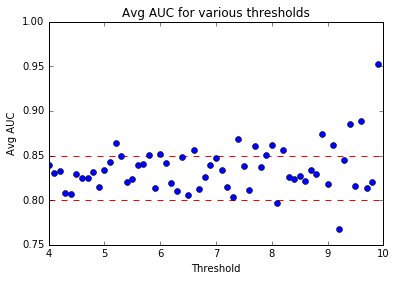

In [159]:
import matplotlib.pyplot as plt
import numpy as np

x = display_df["threshold"]
y = display_df["auc"]

fig, ax = plt.subplots()
#ax.fmt_ydata = millions
plt.title("Avg AUC for various thresholds")

plt.plot((4, 10), (0.8, 0.8), '--',color="red")
plt.plot((4, 10), (0.85, 0.85), '--',color="red")
ax.set_xlabel("Threshold")
ax.set_ylabel("Avg AUC")
plt.plot(x, y, 'o')

print "\nFIGURE-3: Avg. AUC values for various thresholds"
plt.show()

From the above plot, we can infer the following:

* For most of the thresholds, the average AUC values lie between 0.8 and 0.85. 
* As the threshold value increases, the variance of the average AUC values increases.
* The highest AUC value obtained is 0.95, while the least AUC value obtained is 0.77, and both occurred for a threshold value of more than 9. 
* Most of the higher AUC values have occurred for a threshold of 7.5 or more.
* For all the thresholds, the average AUC values are way above 0.5, and this suggests that our recommender is doing a better job than pure random guessing that a user likes an item.

Even though most of the higher AUC values have occurred for a threshold of 7.5 or more, we do not want to use the 7.5 threshold, since we will end up setting the bar high, and the number of recommended items will be less. But setting the threshold to a value of 4, will qualify many items as the recommended items for a user, and may dilute the quality of the recommendations. So, let us choose the threshold value of 5 to determine if a user likes the item. If the predicted rating of an item for a user is more than 5, recommend the item to the user, else do not recommend.

## Recommending jokes based on the predicted ratings by SGD method
We will create a function, that takes the user_ID as input and returns the items recommended to the user ID. We will also provide the predicted ratings matrix as input, along with the ratings data frame (containing all the ratings), and the Utility matrix produced using the ratings data frame. The ratings data frame will help the function to get the list of items which were already rated by the user.

Training the algorithm using the complete ratings data.

In [100]:
#train_df,test_df=split_data(Utility,test_perc=20)
Utility_normalized,Utility_items_mean,Utility_users_mean = normalize(Utility)
U, V, error = SGD_factorization(np.array(Utility_normalized),60, 1, 1, 1000, 0.0000000001, 10,0.00001)
pred = np.dot(U,V) + Utility_items_mean
pred = pred.T + Utility_users_mean
pred = pred.T


The following function will take a user ID as input and gives the list of recommended items as the output.

In [132]:
def get_SGD_recommendations(user_id,ratings_df,pred_utility,Utility):
    #Get the list of jokes, which are already rated by the user:
    already_rated = list(ratings_df[(ratings_df["user_id"] == user_id)]["item_id"])
    
    top_user_ratings = ratings_df[(ratings_df["user_id"] == user_id)].sort(["rating"],ascending=[0]).head(5)
    
    
    
    #Note that the joke IDs are NOT named using consecutive integers
    #Get the items not rated by the user ID
    not_rated = set(ratings_df["item_id"]) - set(already_rated)
    
    
    row_idx = [user_id] * len(not_rated)
    col_idx = list(not_rated)
    #Convert pred matrix to data frame
    pred_df = pd.DataFrame(pred)
    
    #Change the row and column names
    pred_df.index = Utility.index
    pred_df.columns = Utility.columns
    
    #Get ratings at the intersection of the rows and columns list
    ratings = get_ratings(pred_df,row_idx,col_idx,indices=True)
    
    ratings = np.array(ratings)
    
    #Change the ratings to the allowed interval
    ratings[ratings > 10] = 10
    ratings[ratings < -10] = -10
    return [ratings,row_idx,col_idx,top_user_ratings]
    
#Predict the ratings for the user ID 129
user_id = 129
pred_ratings,row_idx,col_idx,top_user_ratings = get_SGD_recommendations(user_id,ratings_df,pred,Utility)
print "The user ID {} has rated these jokes high (top 5 jokes):".format(user_id)
display(top_user_ratings)

display(items_df[items_df["Joke-id"].isin(list(top_user_ratings["item_id"]))])

display_df=pd.DataFrame(zip(row_idx,col_idx,pred_ratings),columns=["user_id","item_id","predicted_ratings"])

display_df["predicted_ratings"].min()
display_df=display_df.sort(["predicted_ratings"],ascending=0)

recommended_items = list(display_df["item_id"])[0:5]
print "Top 5 recommended items for the user ID: {} are given below.".format(user_id)
items_df[items_df["Joke-id"].isin(recommended_items)]

The user ID 129 has rated these jokes high (top 5 jokes):


,user_id,item_id,rating
4819,129,15,-0.781
4816,129,7,-4.906
4815,129,5,-5.438
4818,129,13,-9.562
4817,129,8,-9.719


,Joke-id,Text
4,5,"Q. What's O. J. Simpson's web address? A. Slash, slash, backslash, slash, slash, escape."
6,7,How many feminists does it take to screw in a light bulb? That's not funny.
7,8,Q. Did you hear about the dyslexic devil worshiper? A. He sold his soul to Santa.
12,13,"They asked the Japanese visitor if they have elections in his country. ""Every morning,"" he answers."
14,15,Q: What did the blind person say when given some matzah? A: Who the hell wrote this?


Top 5 recommended items for the user ID: 129 are given below.


,Joke-id,Text
34,35,"An explorer in the deepest Amazon suddenly finds himself surrounded by a bloodthirsty group of natives. Upon surveying the situation, he says quietly to himself, ""Oh God, I'm screwed."" The sky darkens and a voice booms out, ""No, you are NOT screwed. Pick up that stone at your feet and bash in the head of the chief standing in front of you."" So with the stone he bashes the life out of the chief. He stands above the lifeless body, breathing heavily and looking at 100 angry natives... The voice booms out again, ""Okay....NOW you're screwed."""
52,53,"One Sunday morning William burst into the living room and said, ""Dad! Mom! I have some great news for you! I am getting married to the most beautiful girl in town. She lives a block away and her name is Susan."" After dinner, William's dad took him aside. ""Son, I have to talk with you. Your mother and I have been married 30 years. She's a wonderful wife but she has never offered much excitement in the bedroom, so I used to fool around with women a lot. Susan is actually your half-sister, and I'm afraid you can't marry her."" William was heart-broken. After eight months he eventually started dating girls again. A year later he came home and very proudly announced, ""Dianne said yes! We're getting married in June."" Again his father insisted on another private conversation and broke the sad news. ""Dianne is your half-sister too, William. I'm awfully sorry about this."" William was furious! He finally decided to go to his mother with the news. ""Dad has done so much harm.. I guess I'm never going to get married,"" he complained. ""Every time I fall in love, Dad tells me the girl is my half-sister."" His mother just shook her head. ""Don't pay any attention to what he says, dear. He's not really your father."""
67,68,"A man piloting a hot air balloon discovers he has wandered off course and is hopelessly lost. He descends to a lower altitude and locates a man down on the ground. He lowers the balloon further and shouts, ""Excuse me, can you tell me where I am?"" The man below says, ""Yes, you're in a hot air balloon, about 30 feet above this field."" ""You must work in Information Technology,"" says the balloonist. ""Yes I do,"" replies the man. ""And how did you know that?"" ""Well,"" says the balloonist, ""what you told me is technically correct, but of no use to anyone."" The man below says, ""You must work in management."" ""I do,"" replies the balloonist, ""how did you know?"" ""Well,"" says the man, ""you don't know where you are, or where you're going, but you expect my immediate help. You're in the same position you were before we met, but now it's my fault!"""
71,72,"On the first day of college, the Dean addressed the students, pointing out some of the rules: ""The female dormitory will be out-of-bounds for all male students and the male dormitory to the female students. Anybody caught breaking this rule will be finded $20 the first time."" He continued, ""Anybody caught breaking this rule the second time will be fined $60. Being caught a third time will cost you a fine of $180. Are there any questions?"" At this point, a male student in the crowd inquired: ""How much for a season pass?"""
104,105,"A couple of hunters are out in the woods in the deep south when one of them falls to the ground. He doesn't seem to be breathing, and his eyes are rolled back in his head. The other guy whips out his cell phone and calls 911. He gasps to the operator, ""My friend is dead! What can I do?"" The operator, in a calm and soothing voice, says, ""Alright, take it easy. I can help. First, let's make sure he's dead."" There is silence, and then a gun shot is heard. The hunter comes back on the line. ""Okay. Now what??"""


The above display shows that the user ID 129 has rated all the jokes with a negative rating. But our recommender is still able to predict the jokes he likes. But NOTE that we cannot determine if he really likes these jokes, unless we present these jokes to the user and capture his response.

Let us get the recommended jokes for the user ID 17:

In [135]:
user_id = 17
pred_ratings,row_idx,col_idx,top_user_ratings = get_SGD_recommendations(user_id,ratings_df,pred,Utility)
print "The user ID {} has rated these jokes high (top 5 jokes):".format(user_id)
display(top_user_ratings)

display(items_df[items_df["Joke-id"].isin(list(top_user_ratings["item_id"]))])

display_df=pd.DataFrame(zip(row_idx,col_idx,pred_ratings),columns=["user_id","item_id","predicted_ratings"])

display_df["predicted_ratings"].min()
display_df=display_df.sort(["predicted_ratings"],ascending=0)

recommended_items = list(display_df["item_id"])[0:5]
print "Top 5 recommended items for the user ID: {} are given below.".format(user_id)
items_df[items_df["Joke-id"].isin(recommended_items)]

The user ID 17 has rated these jokes high (top 5 jokes):


,user_id,item_id,rating
755,17,17,10.000
766,17,35,10.000
771,17,49,10.000
758,17,20,10.000
770,17,27,9.938


,Joke-id,Text
16,17,How many men does it take to screw in a light bulb? One. Men will screw anything.
19,20,What's the difference between a Macintosh and an Etch-a-Sketch? You don't have to shake the Mac to clear the screen.
26,27,"Bill Clinton returns from a vacation in Arkansas and walks down the steps of Air Force One with two pigs under his arms. At the bottom of the steps, he says to the honor guardsman, ""These are genuine Arkansas Razor-Back Hogs. I got this one for Chelsea and this one for Hillary."" The guardsman replies, ""Nice trade, Sir."""
34,35,"An explorer in the deepest Amazon suddenly finds himself surrounded by a bloodthirsty group of natives. Upon surveying the situation, he says quietly to himself, ""Oh God, I'm screwed."" The sky darkens and a voice booms out, ""No, you are NOT screwed. Pick up that stone at your feet and bash in the head of the chief standing in front of you."" So with the stone he bashes the life out of the chief. He stands above the lifeless body, breathing heavily and looking at 100 angry natives... The voice booms out again, ""Okay....NOW you're screwed."""
48,49,"Three engineering students were gathered together discussing the possible designers of the human body. One said, ""It was a mechanical engineer. Just look at all the joints."" Another said, ""No, it was an electrical engineer. The nervous systems many thousands of electrical connections."" The last said, ""Actually, it was a civil engineer. Who else would run a toxic waste pipeline through a recreational area?"""


Top 5 recommended items for the user ID: 17 are given below.


,Joke-id,Text
62,63,"An engineer, a physicist and a mathematician are sleeping in a room. There is a fire in the room. The engineer wakes up, sees the fire, picks up the bucket of water and douses the fire and goes back to sleep. Again there is a fire in the room. This time, the physicist wakes up, notices the bucket, fills it with water, calculates the optimal trajectory and douses the fire in minimum amount of water and goes back to sleep. Again there is a fire. This time the mathematician wakes up. He looks at the fire, looks at the bucket and the water and exclaims, ""A solution exists!"" and goes back to sleep."
97,98,"Age and Womanhood 1. Between the ages of 13 and 18... She is like Africa, virgin and unexplored. 2. Between the ages of 19 and 35... She is like Asia, hot and exotic. 3. Between the ages of 36 and 45... She is like America, fully explored, breathtakingly beautiful, and free with her resources. 4. Between the ages of 46 and 56... She is like Europe, exhausted but still has points of interest. 5. After 56 she is like Australia... Everybody knows it's down there, but who gives a damn?"
103,104,"As a pre-med student, I had to take a difficult class in physics. One day our professor was discussing a particularly complicated concept. A student rudely interrupted to ask, ""Why do we have to learn this stuff?"" ""To save lives."" The professor responded quickly and continued the lecture. A few minutes later, the same student spoke up again. ""So how does physics save lives?"" he persisted. ""It usually keeps the idiots like you out of medical school,"" replied the professor."
104,105,"A couple of hunters are out in the woods in the deep south when one of them falls to the ground. He doesn't seem to be breathing, and his eyes are rolled back in his head. The other guy whips out his cell phone and calls 911. He gasps to the operator, ""My friend is dead! What can I do?"" The operator, in a calm and soothing voice, says, ""Alright, take it easy. I can help. First, let's make sure he's dead."" There is silence, and then a gun shot is heard. The hunter comes back on the line. ""Okay. Now what??"""
105,106,"An engineer dies and reports to the pearly gates. St. Peter checks his dossier and says, ""Ah, you''re an engineer--you're in the wrong place."" So, the engineer reports to the gates of hell and is let in. Pretty soon, the engineer gets dissatisfied with the level of comfort in hell, and starts designing and building improvements. After awhile, they've got air conditioning, flush toilets and escalators, and the engineer is a pretty popular guy. One day, God calls Satan up on the telephone and says with a sneer, ""So, how's it going down there in hell?"" Satan replies, ""Hey, things are going great. We've got air conditioning, flush toilets and escalators, and there's no telling what this engineer is going to come up with next."" God replies, ""What?? You've got an engineer? That's a mistake--he should never have gotten down there; send him up here."" Satan says, ""No way."" I like having an engineer on the staff, and I'm keeping him."" God says, ""Send him back up here or I'll sue."" Satan laughs uproariously and answers, ""Yeah, right. And just where are YOU going to get a lawyer?"""


We can see that the user liked a joke related to engineering students' topic, and the recommended jokes 63 and 106 are about engineers and 104 is about pre-med *student*. But the recommended jokes are different from the jokes recommended by the collaborative filtering algorithm (which recommended the jokes with IDs: 26, 39, 47,64,105,126). Hence, except the 105 joke, both recommenders have recommended different jokes. Now to determine which recommendation system is superior, we need to perform A/B testing by capturing the real responses from the users. But we can certainly confirm that the SGD algorithm is doing a satisfactory job, since we obtained an AUC scores between 0.8 and 0.85 (for most of the test runs).


## Conclusion
In this project, we developed 2 algorithms to make joke recommendations:
* A Collaborative filtering algorithm based on the cosine similarity and the number of user ratings
* Stochastic Gradient Descent method based on the matrix factorization

For recommendations based on the collaborative filtering, we identified the recommended jokes based on cosine similarity, and if the joke pairs were rated by at least 1000 users. These criteria has given good recommendations. However, this method has the following drabacks:

1. For a new user we do not have a good mechanism to provide recommendations (the cold start problem).

2. We assumed that a rating of greater than 5 implies that the user has liked the joke. This assumption might be incorrect. Based on this criterion, we may not have any jokes to recommend, if a user gives a rating of less than 5 for all the jokes s/he reads.

3. We also restricted the recommended items to the list which were rated by at least 1000 users. This criterion will decrease the number of potential recommendations to the users.

4. For new items, we do not have any ratings available, and we never recommend the new items based on the selection criteria of 1000 common ratings with at least another item. 

For SGD based recommender, we have the following advantages:

1. We are able to predict the ratings for all the items for all the users.

2. We were able to identify optimal rating threshold as 5 to determine if a user likes the item.

3. We were able to run the algorithm on a laptop with 16GB of RAM (the ratings data set has 1.7 Million ratings)

4. We were able to quantify the performance of our algorithm using AUC (Area Under the Curve), and obtained an average AUC score of 0.8, which is a good score since it is way higher than the AUC score of 0.5 (obtained by random guessing).

However the SGD method also does not address cold start problem.

### Future work
I would like to address the following as a part of future work:

* Analyze methods to address the cold start problem.

* Build many recommenders, combine their outputs and analyze if the quality of the recommendations improve.

 

### References:
1. Eigentaste: A Constant Time Collaborative Filtering Algorithm. Ken Goldberg, Theresa Roeder, Dhruv Gupta, and Chris Perkins. Information Retrieval, 4(2), 133-151. July 2001

2. Jure Leskovec, Anand Rajaraman and Jeffrey D. Ullman 2014. Mining of Massive Datasets (Chapter 9)

3. Deepak K. Agarwal and Bee-Chung Chen. Statistical Methods for Recommender Systems

## Appendix - A

The implementation of the cosine similarity computation process is explained using a small data set. The same logic is applicable to the massive data sets.

## Example:

Let us assume that we have the following ratings for some of the jokes:

<img src="toy-example.png">

The above figure shows the normalized ratings. These normalized ratings will be converted to an RDD with user ID as the key (the RDD is displayed below):

<img src="RDD-1.png">

Let us consider the first element highlighted in red color. This element specifies that the user ID 1 has given a normalized rating of -2.2 to joke 1. The second element highlighted in blue color specifies that the user ID 1 has given a normalized rating of -5.7 to joke 4.

This RDD is self-joined with itself (on the join condition of USER-ID = USER-ID). The resultant RDD is filtered further to avoid duplicate combinations. For example, for the user ID 4, we will get the following elements (not all permutations are shown):

<img src="RDD-2a.png">

Consider the second element of the above list. (4, ((1, -6.5), (1, -6.5))), which is highlighted in red. This element is showing the combination of the same joke ID 1. Such elements can be eliminated. Consider third and 4th elements: (4, ((2, -5.0),(1, -6.5))),
(4, ((1, -6.5), (2, -5.0))), which are highlighted in green and blue respectively. Both represent the same combinations. We only need one element from such duplicate combinations. So, we will filter the elements and include only the elements if and only if the joke ID of the first value is less than the joke ID of the second value. This filter condition will eliminate the second and third rows. When the same condition is applied on the whole data set, we will get the following elements:

<img src="RDD-2.png">

The above RDD is further reduced, by extracting the joke IDs from the values, making the joke IDs as the keys and making the ratings as the values. Note that the user ID is dropped. We will get the following RDD:

<img src="RDD-3.png">


The above RDD shows the combinations/pairs of jokes, which are rated by at least one user. For example, one user (highlighted in red) has rated the jokes (1,4) pairs as (-2.2, -5.7) and another user (highlighted in blue) has rated the same joke pairs as (-5.25, -2.75). This RDD is further reduced by grouping the keys (joke pairs) and getting the cosine similarity between the values. For example, for the joke pairs (1,4), we have the following ratings provided by two users: (-2.2, -5.7) and (-5.25, -2.75). Getting the cosine similarity between the vectors $[-2.2, -5.25]$ and $[-5.7, -2.75]$ give us 0.7518. This measure is captured along with the number of users who rated both the movies (in this example, we have 2 users who rated 1,4 movies)

This filter will give us the following RDD:

<img src="RDD-4.png">

The above RDD is written to a HDFS file, and this data set will be used to provide recommendations. For instance, if a user has liked the joke-6, and he has not seen the joke-1, then we can recommend joke-1 to him, since the cosine similarity is 0.95.

The following code block shows the actual Python code written using PySpark to obtain the cosine similarity of the example data set shown above. This code was written on windows machine with 6 GB RAM, running Spark. The same code (with minor modifications) will be used to run on the bigger data set (with 1.7 Million ratings) on a Hadoop cluster. NOTE that the following code does NOT normalize the ratings automatically. But we will be supplying the data set with normalized ratings as input. But in the implementation of the same program in Hadoop environment, we will also include the logic to normalize the ratings.

In [ ]:
from pyspark import SparkConf, SparkContext
from math import sqrt
import sys

## Function to remove duplicate ratings
def filterDuplicates((userID, ratings)):
    (joke1,rating1) = ratings[0]
    (joke2,rating2) = ratings[1]
    return joke1 < joke2
 
## Cosine similarity function    
def computeCosineSimilarity(ratingPairs):
    numPairs = 0
    sum_xx = sum_yy = sum_xy = 0
    for ratingX, ratingY in ratingPairs:
        sum_xx += ratingX * ratingX
        sum_yy += ratingY * ratingY
        sum_xy += ratingX * ratingY
        numPairs += 1
 
    numerator = sum_xy
    denominator = sqrt(sum_xx) * sqrt(sum_yy)
 
    score = 0
    if (denominator):
        score = (numerator / (float(denominator)))
 
    return (score, numPairs)
 
## Make joke pairs as the keys, and their ratings as the values    
def makePairs((user, ratings)):
    (joke1, rating1) = ratings[0]
    (joke2, rating2) = ratings[1]
    return ((joke1, joke2), (rating1, rating2))
 

## Define conf object to run on local machine    
conf = SparkConf().setMaster("local").setAppName("Ratings..")

## Define SparkContext
sc = SparkContext(conf = conf)
 
data = sc.textFile("toy_data.csv")


print "Read the file..."
ratings = data.map(lambda x: x.split(",")).map(lambda x: (int(x[0]),(int(x[1]),float(x[2]))))

display_df = ratings.collect()

for i in display_df:
    print i

print "Prepared the ratings RDD..."

## Have to partition the data set when running on a cluster
#ratingsPartitioned = ratings.partitionBy(100)
#print "Partitioned the ratings into 100 parts..."

ratingsPartitioned = ratings

## Self Join
joinedRatings = ratingsPartitioned.join(ratingsPartitioned)
print "Self join completed ..."
 
##Filter duplicate ratings in the join RDD    
uniqueJoinedRatings = joinedRatings.filter(filterDuplicates)
print "Filtered the duplicates..."

display_df = uniqueJoinedRatings.collect()

for i in display_df:
    print i


#jokePairs = uniqueJoinedRatings.map(makePairs).partitionBy(100)
jokePairs = uniqueJoinedRatings.map(makePairs)


display_df = jokePairs.collect()

for i in display_df:
    print i

jokePairRatings = jokePairs.groupByKey()

print "Computing the cosine similarity ..."
jokePairSimilarities = jokePairRatings.mapValues(computeCosineSimilarity).persist()
 
print "Sorting the results..."
 
jokePairSimilarities.sortByKey()

display_df = jokePairSimilarities.collect()
for i in display_df:
    print i

print "Saving the results..."
jokePairSimilarities.saveAsTextFile("joke-sims")

print "script ends..."


## Appendix-B

## Downloading the files and running the pyspark program

FTP the jester_ratings.dat file to a directory in Linux machine, and move the file jester_ratings.dat to the HDFS filesystem, using the following command:

       hadoop fs -put <local_directory>/jester_ratings.dat  <hadoop_dir> 

To run the pyspark program in Hadoop, use the following command:

       spark-submit --master yarn-client --executor-memory 1g <program_name>

The program will create 100 files in HDFS (since we used 100 partitions in our pyspark program). To combine these 100 files and download to the local Linux folder, run the following command:

       hadoop fs -getmerge <Hadoop home dir>/joke-sims/ jokes_sim.txt


**Example:**

If you have downloaded jester_ratings.dat to /home/sekhar/ directory, you may copy the file to Hadoop File system as follows:

1. Create a HDFS directory "data" in /user/sekhar directory (which is in HDFS), use the following command: 

        hadoop fs -mkdir /user/sekhar/data  
        
2. To copy the downloaded file to /user/sekhar/data HDFS directory, use the following command:
        
        hadoop fs -put /home/sekhar/jester_ratings.dat  /user/sekhar/data

3. To run the pyspark program which finds the similarity score, copy the code given in the next block to a file on one of the linux machines in the cluster. For example, if you have copied the code to the file jester_1.py, execute the following command to run:

        spark-submit --master yarn-client --executor-memory 1g jester_1.py

4. The above command will create 100 HDFS files. These files can be combined into one file and can be downloaded to a local Linux directory:

        hadoop fs -getmerge /user/sekhar/joke-sims/ jokes_sim.txt
       
where /user/sekhar/ is the Hadoop home directory, where the files are created. The joke-sims directory in /user/sekhar/ contains the 100 files.

Download the jokes_sim.txt to your local machine, and perform the analysis. This file contains the similarity scores between the jokes.


PySpark code to compute the cosine similarity between the pairs of jokes rated by at least one user is given below. 

In [ ]:
import sys
from pyspark import SparkConf, SparkContext
from math import sqrt


##To run: Copy this program to a file named "jester_1.py" and execute the following command:
## spark-submit --master yarn-client --executor-memory 1g jester_1.py

## Logic:
## The following steps will normalize the ratings:
## 1. Get the average ratings of all the users given to various items
## 2. Get the average ratings of all the items given by various users 
## 3. Subtract the average ratings of the respective user and the respective item
##    from the actual rating given by a user to an item
## The following step will compute the cosine similarity between all the pairs of jokes
## which are rated by at least one user
## 4. Compute the cosine similarity between the pairs of jokes
##

print "Starting the script ..."

## filterDuplicates will remove the duplicates 
def filterDuplicates( (userID, ratings) ):
    (joke1, rating1) = ratings[0]
    (joke2, rating2) = ratings[1]
    return joke1 < joke2

## computeCosineSimilarity will compute the cosine similarity
def computeCosineSimilarity(ratingPairs):
    numPairs = 0
    sum_xx = sum_yy = sum_xy = 0
    for ratingX, ratingY in ratingPairs:
        sum_xx += ratingX * ratingX
        sum_yy += ratingY * ratingY
        sum_xy += ratingX * ratingY
        numPairs += 1

    numerator = sum_xy
    denominator = sqrt(sum_xx) * sqrt(sum_yy)

    score = 0
    if (denominator):
        score = (numerator / (float(denominator)))

    return (score, numPairs)

## makes the pairs of jokes as the keys, and their ratings as the values
def makePairs((user, ratings)):
    (joke1, rating1) = ratings[0]
    (joke2, rating2) = ratings[1]
    return ((joke1, joke2), (rating1, rating2))

## Subtract the users average ratings from the jokes ratings.
## The output RDD will have the joke ID as the key
def normalizeByUser((user_id,ratings)):
    (part_1,avg) = ratings
    normalized=part_1[1] - avg
    #The key will be the joke ID in the returned RDD
    return (part_1[0],(user_id,normalized))
## Subtract the jokes average ratings from the respective jokes
## The input RDD will be the result of the join between the RDD 
## obtained by normalizeByUser() function, and the average jokes ratings RDD
## The output of this function will be an RDD with user ID as the key
def normalizeByJoke((joke_id,ratings)):
    (part_1,avg) = ratings
    normalized=part_1[1] - avg
    #The key will be the user ID in the returned RDD
    return (part_1[0],(joke_id,normalized))


## Main script
conf = SparkConf()
sc = SparkContext(conf = conf)

data = sc.textFile("hdfs:///user/a152700/data/jester_ratings.dat")

##To test on toy.csv data set, uncomment the following statement, and comment the 
##above statement
#data = sc.textFile("file:///home/a152700/spark/programs/toy.csv")
print "Read the file..."
joke_ratings = data.map(lambda x: x.split()).map(lambda x: (int(x[1]),float(x[2])))
user_ratings = data.map(lambda x: x.split()).map(lambda x: (int(x[0]),float(x[2])))
ratings = data.map(lambda x: x.split()).map(lambda x: (int(x[0]),(int(x[1]),float(x[2]))))

print "Prepared the ratings RDD..."

joke_ratingsPartitioned = joke_ratings.partitionBy(100)
print "Partitioned the joke ratings into 100 parts..."

user_ratingsPartitioned = user_ratings.partitionBy(100)
print "Partitioned the user ratings into 100 parts..."

ratingsPartitioned = ratings.partitionBy(100)
print "Partitioned the whole  ratings into 100 parts..."

##Get the average joke ratings
joke_ratings_rdd = joke_ratings.mapValues(lambda x: (x,1)).reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
joke_ratings_avg = joke_ratings_rdd.mapValues(lambda x: x[0]/x[1]).persist()

##Get the average user ratings
user_ratings_rdd = user_ratings.mapValues(lambda x: (x,1)).reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
user_ratings_avg = user_ratings_rdd.mapValues(lambda x: x[0]/x[1]).persist()

#Joining user_ratings_avg and ratings
user_ratings_joined = ratingsPartitioned.join(user_ratings_avg)
user_ratings_normalized = user_ratings_joined.map(normalizeByUser)
#The user_ratings_normalized RDD will have the joke ID as the key
#The ratings are normalized using the avg. user rating

display_rdd = user_ratings_joined.collect()

for i in range(10):
     print display_rdd[i]

display_rdd = user_ratings_normalized.collect()

for i in range(10):
     print display_rdd[i]



#Joining joke_ratings_avg and ratings
joke_ratings_joined = user_ratings_normalized.join(joke_ratings_avg)
joke_ratings_normalized = joke_ratings_joined.map(normalizeByJoke) 
#The joke_ratings_normalized RDD will have the user ID as the key
#The ratings are normalized using the avg. joke rating

display_rdd = joke_ratings_normalized.collect()

for i in range(10):
     print display_rdd[i]


#joke_ratings_avg_sorted = joke_ratings_avg.sortByKey() 

#joke_ratings_avg_sorted.saveAsTextFile("joke-avg")

#user_ratings_avg_sorted = user_ratings_avg.sortByKey()

#user_ratings_avg_sorted.saveAsTextFile("user-avg")



#display_rdd = rdd.collect()

#for i in range(10):
#     print display_rdd[i]


##Computing the similarities of jokes using the normalized ratings:
##joke_ratings_normalized
print "Normalization of ratings complete..."
print "Now computing the similarities..."

ratingsPartitioned = joke_ratings_normalized.partitionBy(100)

print "script ends..."

print "Partitioned the ratings into 100 parts..."

joinedRatings = ratingsPartitioned.join(ratingsPartitioned)
print "Self join completed ..."

uniqueJoinedRatings = joinedRatings.filter(filterDuplicates)
print "Filtered the duplicates..."

jokePairs = uniqueJoinedRatings.map(makePairs).partitionBy(100)

jokePairRatings = jokePairs.groupByKey()
print "Computing the cosine similarity ..."
jokePairSimilarities = jokePairRatings.mapValues(computeCosineSimilarity).persist()

print "Sorting the results..."

jokePairSimilarities.sortByKey()

print "Saving the results..."
jokePairSimilarities.saveAsTextFile("joke-sims")
display_rdd = jokePairSimilarities.collect()

for i in range(10):
     print display_rdd[i]